In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
%matplotlib inline

from prada.ghsom_model.utils import mean_data_centroid_activation
from prada.ghsom_model.utils import dispersion_rate

In [2]:
# method for displaying a scrollable dataframe
from IPython.display import display, HTML

def display_scrollable_dataframe_with_sticky_header(df):
    display(HTML(
        df.to_html(notebook=True, index=False).replace(
            '<table border="1" class="dataframe">', 
            '<table border="1" class="dataframe" style="max-height: 500px; display: block; overflow: auto;">'
        ).replace('<thead>', '<thead style="position: sticky; top: 0; background-color: white; color: black; z-index: 1;">')
    ))

In [3]:
# Load the processed scorenorm dataset
with open('data_scorenorm/combined_data_score_norms_v2.pkl', 'rb') as file:
    combined_data = pickle.load(file)

In [4]:
score_norms_abcd_val = combined_data['score_norms']['abcd-val']
score_norms_abcd_test = combined_data['score_norms']['abcd-test']
score_norms_ibis_typical = combined_data['score_norms']['ibis-inlier']
score_norms_ibis_hr_typical = combined_data['score_norms']['ibis-hr-inliers']
score_norms_ibis_atypical = combined_data['score_norms']['ibis-atypical']
score_norms_ibis_asd = combined_data['score_norms']['ibis-asd']
score_norms_ibis_ds = combined_data['score_norms']['ibis-ds-sa']

score_norms_abcd = np.concatenate([score_norms_abcd_val, score_norms_abcd_test], axis=0)
score_norms_abcd.shape, score_norms_ibis_typical.shape

((330, 1, 20), (82, 1, 20))

In [5]:
identifiers_abcd_val = combined_data['identifier']['abcd-val']
identifiers_abcd_test = combined_data['identifier']['abcd-test']
identifiers_ibis_typical = combined_data['identifier']['ibis-inlier']
identifiers_ibis_hr_typical = combined_data['identifier']['ibis-hr-inliers']
identifiers_ibis_atypical = combined_data['identifier']['ibis-atypical']
identifiers_ibis_asd = combined_data['identifier']['ibis-asd']
identifiers_ibis_ds = combined_data['identifier']['ibis-ds-sa']

identifiers_abcd = np.concatenate([identifiers_abcd_val, identifiers_abcd_test], axis=0)
identifiers_abcd.shape

(330,)

In [6]:
print('score_norms_abcd_val\t\t', score_norms_abcd_val.shape)
print('score_norms_abcd_test\t\t', score_norms_abcd_test.shape)
print('score_norms_abcd\t\t', score_norms_abcd.shape)
print('score_norms_ibis_typical\t', score_norms_ibis_typical.shape)
print('score_norms_ibis_hr_typical\t', score_norms_ibis_hr_typical.shape)
print('score_norms_ibis_atypical\t', score_norms_ibis_atypical.shape)
print('score_norms_ibis_asd\t\t', score_norms_ibis_asd.shape)
print('score_norms_ibis_ds\t\t', score_norms_ibis_ds.shape)

score_norms_abcd_val		 (165, 1, 20)
score_norms_abcd_test		 (165, 1, 20)
score_norms_abcd		 (330, 1, 20)
score_norms_ibis_typical	 (82, 1, 20)
score_norms_ibis_hr_typical	 (106, 1, 20)
score_norms_ibis_atypical	 (38, 1, 20)
score_norms_ibis_asd		 (65, 1, 20)
score_norms_ibis_ds		 (28, 1, 20)


In [7]:
score_norms_abcd_val = np.squeeze(score_norms_abcd_val)
score_norms_abcd_test = np.squeeze(score_norms_abcd_test)
score_norms_abcd = np.squeeze(score_norms_abcd)
score_norms_ibis_typical = np.squeeze(score_norms_ibis_typical)
score_norms_ibis_hr_typical = np.squeeze(score_norms_ibis_hr_typical)
score_norms_ibis_atypical = np.squeeze(score_norms_ibis_atypical)
score_norms_ibis_asd = np.squeeze(score_norms_ibis_asd)
score_norms_ibis_ds = np.squeeze(score_norms_ibis_ds)

In [8]:
dataset_id_to_name = {-1: "ABCD", 0:"LR-Typical", 1:"HR-Typical", 2:"Atypical", 3:"Down Syndrome", 4:"ASD"}
dataset_name_to_id = {v:k for k,v in dataset_id_to_name.items()}
dataset_list = [score_norms_abcd, score_norms_ibis_typical, score_norms_ibis_hr_typical, score_norms_ibis_atypical, score_norms_ibis_ds, score_norms_ibis_asd]

X_data = np.concatenate(dataset_list, axis=0)
y_labels = np.concatenate([[i-1]*len(d) for i,d in enumerate(dataset_list)])

assert len(y_labels)==len(X_data)
inlier_data = X_data[y_labels <= 0]
test_data = X_data[y_labels > 0]
test_labels = y_labels[y_labels > 0]
train_labels = y_labels[y_labels <= 0]

mu, std = np.mean(inlier_data, axis=0), np.std(inlier_data, axis=0)
inlier_data = (inlier_data - mu) / std
test_data = (test_data  - mu) / std

dssamples = test_data[test_labels == dataset_name_to_id["ASD"]]
X_data.shape, inlier_data.shape, len(dssamples), test_data.shape

((649, 20), (412, 20), 65, (237, 20))

In [9]:
# This is for stacking identifiers to be mapped to the trained GHSOM.
identifiers_list = [identifiers_abcd, identifiers_ibis_typical, identifiers_ibis_hr_typical, identifiers_ibis_atypical, identifiers_ibis_ds, identifiers_ibis_asd]
indentifiers_data = np.concatenate(identifiers_list, axis=0)
inlier_identifiers = indentifiers_data[y_labels <= 0] 
test_identifiers = indentifiers_data[y_labels > 0]

In [10]:
# Some people suggest to keep the ratio of the height and width
# to be the ratio of the first two principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=5).fit(inlier_data)
print(pca.explained_variance_ratio_, pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1])

num_neurons = 5*np.sqrt(test_data.shape[0])
grid_size = int(np.ceil(np.sqrt(num_neurons)))

ratio = pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1]
h = np.sqrt(num_neurons / ratio)
w = h*ratio
ratio, h,w, num_neurons

[0.779983   0.11797428 0.05953304 0.02628103 0.00753446] 6.6114664


(6.6114664, 3.4121113142534965, 22.559059333778997, 76.97402159170326)

In [11]:
from collections import OrderedDict
from prada.ghsom_model.GHSOM import GHSOM
from prada.ghsom_model.GSOM import GSOM

In [12]:
n_samples, n_features = inlier_data.shape
print("dataset length: {}".format(n_samples))
print("features per example: {}".format(n_features))

dataset length: 412
features per example: 20


In [13]:
# dummy labels for interactive_plot_with_labels()
labels = np.zeros(n_samples)

In [14]:
def formatted_time(time):
    # Calculate hours, minutes, seconds, and subseconds
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    subseconds = int((time % 1) * 100)  # Subseconds as centiseconds
    return f"hr:min:sec:msc: {hours:02} : {minutes:02} : {seconds:02} : {subseconds:03}"

In [ ]:
# training is done by running train_ghsom_abcd_ibis_inliers.py This function is not used here.
import itertools
import time
import pickle
# Function that encapsulates the training process for a single pair of t1 and t2
def train_ghsom(t1, t2, inlier_data, counter, counters):
    # Check if t1 and t2 are arrays or scalars
    if isinstance(t1, np.ndarray):
        t1_r = np.round(t1, 3)
    else:
        t1_r = round(t1, 3)

    if isinstance(t2, np.ndarray):
        t2_r = np.round(t2, 3)
    else:
        t2_r = round(t2, 3)

    ghsom = GHSOM(input_dataset=inlier_data, t1=t1, t2=t2, learning_rate=0.15, decay=0.95, gaussian_sigma=1.5)

    start_time = time.time()
    print(f"{counter}/{counters}.............................")
    print(f"Training... \t t1={t1_r} \t t2={t2_r},")

    zero_unit = ghsom.train(epochs_number=2, dataset_percentage=1.0, min_dataset_size=30, seed=0, grow_maxiter=10)

    end_time = time.time()
    print(f"Execution time: {(end_time - start_time)}")
    print(f"Execution time: {formatted_time(end_time - start_time)}")

    # Save the trained model
    zero_unit_path = f'ghsom_outputs/trained_maps/trained_z_unit_grid_v11/{t1_r}_{t2_r}_ep-2_mx-it-10_v1_zu.pkl'
    with open(zero_unit_path, 'wb') as f:
        pickle.dump(zero_unit, f)
    print("zero_unit object saved!")

In [16]:
# Create a logarithmic scale between 0.01 and 1
log_scale_min_t1, log_scale_max_t1, number_of_points_t1 = 0.025, 0.045, 5
log_scale_min_t2, log_scale_max_t2, number_of_points_t2 = 0.008, 0.01, 5

log_scale_t1 = np.logspace(np.log10(log_scale_min_t1), np.log10(log_scale_max_t1), num=number_of_points_t1)  # num: defines the number of points
log_scale_t2 = np.logspace(np.log10(log_scale_min_t2), np.log10(log_scale_max_t2), num=number_of_points_t2)  # num: defines the number of points
print("log_scale_t1:",log_scale_t2)
print("log_scale_t2:",log_scale_t2)

log_scale_t1: [0.008      0.00845897 0.00894427 0.00945742 0.01      ]
log_scale_t2: [0.008      0.00845897 0.00894427 0.00945742 0.01      ]


In [17]:
# training is done by running train_ghsom_map.py. This code is not used here.

'''

from joblib import Parallel, delayed
# Generate all combinations of t1 and t2 using itertools.product
t1_t2_combinations = list(itertools.product(log_scale_t1, log_scale_t2))

# Total number of combinations
counters = len(t1_t2_combinations)

start_t = time.time()

# Parallelize the training process using joblib
Parallel(n_jobs=-1)(delayed(train_ghsom)(t1, t2, inlier_data, counter + 1, counters)
                    for counter, (t1, t2) in enumerate(t1_t2_combinations))

end_t = time.time()
print(f"Total Execution time: {formatted_time(end_t - start_t)}")
'''

'\n\nfrom joblib import Parallel, delayed\n# Generate all combinations of t1 and t2 using itertools.product\nt1_t2_combinations = list(itertools.product(log_scale_t1, log_scale_t2))\n\n# Total number of combinations\ncounters = len(t1_t2_combinations)\n\nstart_t = time.time()\n\n# Parallelize the training process using joblib\nParallel(n_jobs=-1)(delayed(train_ghsom)(t1, t2, inlier_data, counter + 1, counters)\n                    for counter, (t1, t2) in enumerate(t1_t2_combinations))\n\nend_t = time.time()\nprint(f"Total Execution time: {formatted_time(end_t - start_t)}")\n'

In [18]:
for t1 in log_scale_t1:
    for t2 in log_scale_t2:
        print(f"{round(t1,3)}\t\t{round(t2,3)}")

0.025		0.008
0.025		0.008
0.025		0.009
0.025		0.009
0.025		0.01
0.029		0.008
0.029		0.008
0.029		0.009
0.029		0.009
0.029		0.01
0.034		0.008
0.034		0.008
0.034		0.009
0.034		0.009
0.034		0.01
0.039		0.008
0.039		0.008
0.039		0.009
0.039		0.009
0.039		0.01
0.045		0.008
0.045		0.008
0.045		0.009
0.045		0.009
0.045		0.01


In [19]:
import sys
import os

In [ ]:
!ls prada/ghsom_model/

GHSOM.py  GSOM.py  neuron/  __pycache__/  README.md  utils.py


In [21]:
from prada.mapping import map_test_data_to_neurons
from prada.mapping import load_and_map_zero_units

In [22]:
sys.path.append(os.path.abspath("."))  
sys.path.append(os.path.abspath(".."))  
sys.path.append(os.path.abspath("prada/ghsom_model"))  

# pickle needs to know where to find the neuron module and GSOM module
from prada.ghsom_model import neuron
import prada.ghsom_model.GSOM as GSOM


In [23]:
# Load and map the zero units, storing the results for each t1-t2 combination
mapped_units = load_and_map_zero_units("ghsom_outputs/trained_maps/trained_z_unit_grid_v08", "ep-2000_mx-it-10_v2_zu.pkl", log_scale_t1, log_scale_t2, inlier_data, train_labels, inlier_identifiers, test_data, test_labels, test_identifiers)

zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.025_0.008_ep-2000_mx-it-10_v2_zu.pkl
zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.025_0.008_ep-2000_mx-it-10_v2_zu.pkl
zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.025_0.009_ep-2000_mx-it-10_v2_zu.pkl
zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.025_0.009_ep-2000_mx-it-10_v2_zu.pkl
zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.025_0.01_ep-2000_mx-it-10_v2_zu.pkl
zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.029_0.008_ep-2000_mx-it-10_v2_zu.pkl
zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.029_0.008_ep-2000_mx-it-10_v2_zu.pkl
zero_unit object loaded from: ==>    ghsom_outputs/trained_maps/trained_z_unit_grid_v08/0.029_0.009_ep-2000_mx-i

In [24]:
from prada.metrics import get_data_mapped_counts_list
from prada.metrics import count_total_neurons
from prada.metrics import calculate_quantization_error
from prada.metrics import are_neurons_neighbours
from prada.metrics import calculate_distance
from prada.metrics import find_bmu1_and_bmu2
from prada.metrics import calculate_topographic_error_for_neuron
from prada.metrics import calculate_neighborhood_distances_for_map
from prada.metrics import calculate_mean_inter_neuron_distance

In [25]:
from prada.metrics import is_leaf_neuron
from prada.metrics import calculate_metrics_for_leaf_neurons
from prada.metrics import calculate_leaf_neuron_metrics

In [26]:
from prada.distribution import calculate_entropy
from prada.distribution import calculate_and_plot_entropy_and_neurons
from prada.distribution import plot_entropy_colormap
from prada.distribution import plot_neuron_colormap

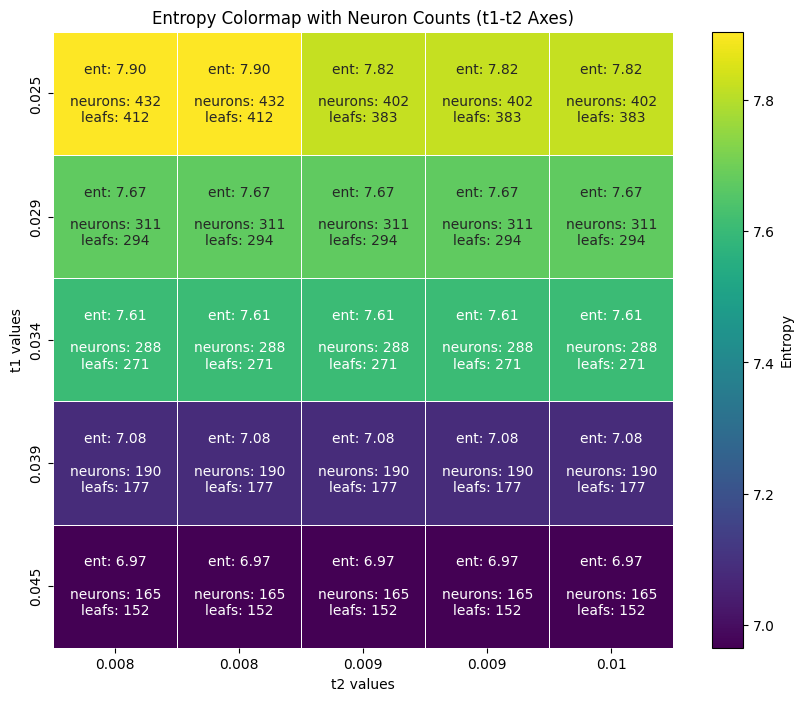

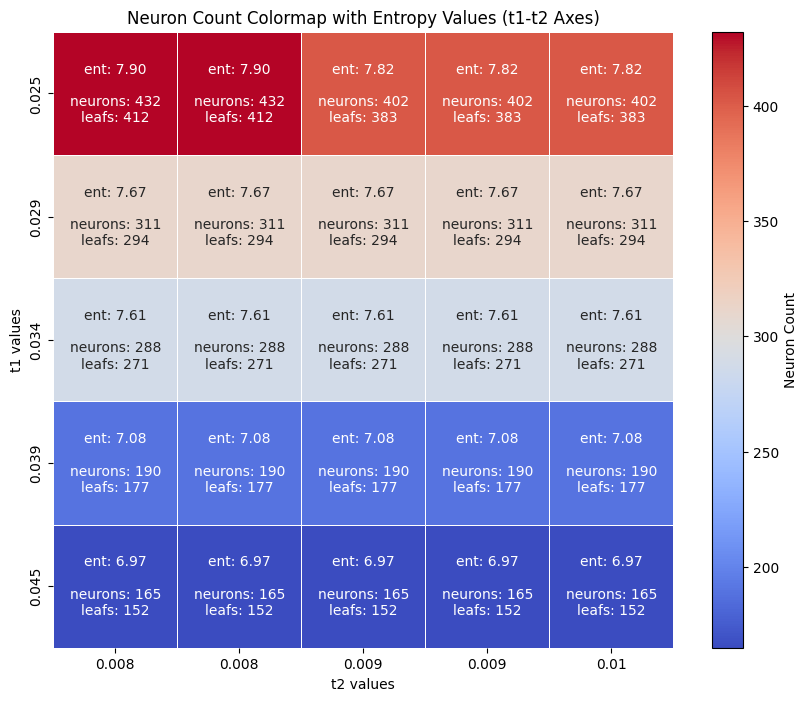

Minimum entropy: 6.97
Maximum entropy: 7.90


In [27]:
# Calculate entropy values for each t1-t2 pair
calculate_and_plot_entropy_and_neurons(mapped_units, log_scale_t1, log_scale_t2)

In [28]:
import matplotlib.pyplot as plt

def plot_histograms_for_leaf_data_with_individual_axes(mapped_units, log_scale_t1, log_scale_t2):
    """
    Plot histograms for the data counts at leaf nodes in a grid, with individual y-axis scaling
    and axis labels for each histogram. Display t1 and t2 values on the outer axes.
    
    :param mapped_units: Dictionary containing the mapped units (train and test) for each (t1_r, t2_r) pair
    :param log_scale_t1: List of t1 values used for the y-axis
    :param log_scale_t2: List of t2 values used for the x-axis
    """
    num_rows = len(log_scale_t1)
    num_cols = len(log_scale_t2)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12), sharex=False, sharey=False)
    fig.suptitle("Histograms of Mapped Training Data at Leaf Nodes", fontsize=16)

    # Iterate over t1 and t2 values to create histograms for each parameter set
    for i, t1 in enumerate(log_scale_t1):
        for j, t2 in enumerate(log_scale_t2):
            t1_r = round(t1, 3)
            t2_r = round(t2, 3)

            # Access the train_mapped_zero_unit for the current (t1_r, t2_r) combination
            train_mapped_zero_unit = mapped_units.get((t1_r, t2_r), {}).get("train_mapped_zero_unit")
            
            ax = axes[i, j]
            if train_mapped_zero_unit:
                # Calculate data_mapped_counts for the leaf nodes
                metrics_for_zero_unit = calculate_leaf_neuron_metrics(train_mapped_zero_unit)
                data_mapped_counts = get_data_mapped_counts_list(metrics_for_zero_unit)

                # Plot histogram of data counts at leaf nodes with individual y-axis scaling
                ax.hist(data_mapped_counts, bins=20, color='skyblue', edgecolor='black')
                ax.set_title(f"t1: {t1_r}, t2: {t2_r}", fontsize=8)

                # Set y-axis limit based on the maximum count for this histogram
                if data_mapped_counts:
                    ax.set_ylim(0, max(data_mapped_counts))
            
            else:
                ax.text(0.5, 0.5, "N/A", ha='center', va='center', fontsize=10, color='red')
            
            # Include individual axis labels
            ax.set_xlabel("Data Counts", fontsize=8)
            ax.set_ylabel("Frequency", fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=7)
    
    # Set outer x and y labels for t1 and t2 values
    fig.supxlabel("t2 Values", fontsize=12)
    fig.supylabel("t1 Values", fontsize=12)
    
    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])  # Adjust layout to fit everything neatly
    plt.show()


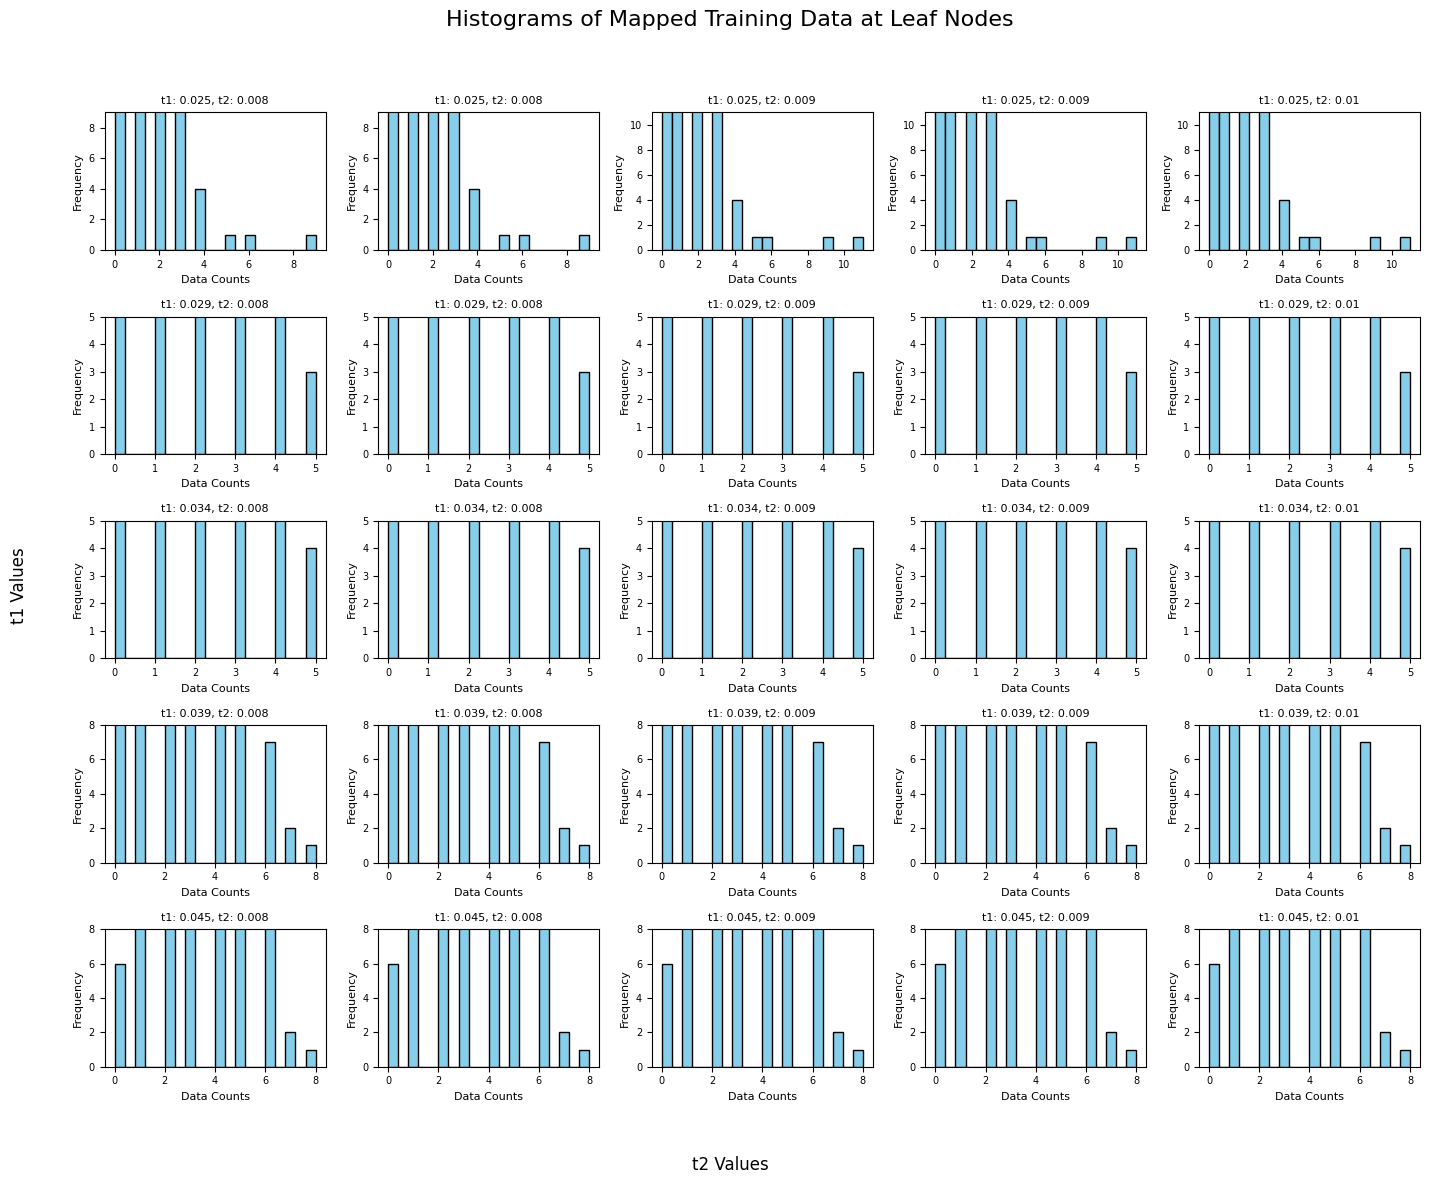

In [29]:
plot_histograms_for_leaf_data_with_individual_axes(mapped_units, log_scale_t1, log_scale_t2)

In [30]:
from prada.distribution import analyze_grouped_data_distribution_with_percentage
from prada.distribution import summarize_neuron_data_distribution

In [31]:
# access the train and test mapped zero units for a specific t1_r and t2_r
t1_r = 0.034  # Example rounded t1 value
t2_r = 0.008  # Example rounded t2 value

# or randomly select
#t1_r = round(log_scale_t1[0],3)  # Example rounded t1 value
#t2_r = round(log_scale_t2[0],3)  # Example rounded t2 value

train_mapped_zero_unit = mapped_units.get((t1_r, t2_r), {}).get("train_mapped_zero_unit")
test_mapped_zero_unit = mapped_units.get((t1_r, t2_r), {}).get("test_mapped_zero_unit")
zero_unit = mapped_units.get((t1_r, t2_r), {}).get("zero_unit")

if train_mapped_zero_unit and test_mapped_zero_unit:
    print(f"Successfully accessed mapped units for t1={t1_r}, t2={t2_r}")
else:
    print(f"No mapped units found for t1={t1_r}, t2={t2_r}")

Successfully accessed mapped units for t1=0.034, t2=0.008


In [32]:
distribution_df = analyze_grouped_data_distribution_with_percentage(mapped_units, t1_r, t2_r)

# Display the result if available
if distribution_df is not None:
    display_scrollable_dataframe_with_sticky_header(distribution_df)

Grouped data distribution for t1: 0.034, t2: 0.008


Data Points Mapped,Number of Neurons,Total Data Mapped,Percentage of Data Mapped,Total Percentage of Data Mapped
0,48,0,0.000000,0.000000
1,107,107,0.242718,25.970874
2,65,130,0.485437,31.553398
3,33,99,0.728155,24.029126
4,14,56,0.970874,13.592233
5,4,20,1.213592,4.854369


In [33]:
summarize_neuron_data_distribution(mapped_units, t1_r, t2_r, 1)

Summary for t1: 0.034, t2: 0.008
Number of neurons with and more than 1 samples: 223
Number of neurons with and less than 1 samples: 48
Total number of leaf neurons: 271
Total number of samples: 412


In [34]:
count_total_neurons(train_mapped_zero_unit)

288

In [35]:
def plot_bar_plots_for_sample_distribution(mapped_units, log_scale_t1, log_scale_t2):
    """
    Plot bar plots for each t1 and t2 combination, showing the number of samples (x-axis)
    and the number of neurons (y-axis), adjusting the y-limits independently and avoiding
    overcrowded x-ticks.
    
    :param mapped_units: Dictionary containing the mapped units (train and test) for each (t1_r, t2_r) pair
    :param log_scale_t1: List of t1 values used for the y-axis
    :param log_scale_t2: List of t2 values used for the x-axis
    """
    num_rows = len(log_scale_t1)
    num_cols = len(log_scale_t2)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12), sharex=False, sharey=False)
    fig.suptitle("Bar Plots of Sample Distribution Across Neurons", fontsize=16)

    # Iterate over t1 and t2 values to create bar plots for each parameter set
    for i, t1 in enumerate(log_scale_t1):
        for j, t2 in enumerate(log_scale_t2):
            t1_r = round(t1, 3)
            t2_r = round(t2, 3)

            # Access the train_mapped_zero_unit for the current (t1_r, t2_r) combination
            train_mapped_zero_unit = mapped_units.get((t1_r, t2_r), {}).get("train_mapped_zero_unit")
            
            ax = axes[i, j]
            if train_mapped_zero_unit:
                # Calculate data_mapped_counts for the leaf nodes
                metrics_for_zero_unit = calculate_leaf_neuron_metrics(train_mapped_zero_unit)
                data_mapped_counts = get_data_mapped_counts_list(metrics_for_zero_unit)
                
                # Create a DataFrame to count the number of neurons with the same number of samples
                data_distribution = pd.DataFrame({'Data Points Mapped': data_mapped_counts})
                grouped_distribution = data_distribution.groupby('Data Points Mapped').size().reset_index(name='Number of Neurons')

                # Adjust y-limits independently using the maximum value
                max_neurons = grouped_distribution['Number of Neurons'].max()
                ax.set_ylim(0, max_neurons + 1)  # Add a small margin for better visibility

                # Plot bar plot
                ax.bar(grouped_distribution['Data Points Mapped'], grouped_distribution['Number of Neurons'], color='skyblue')
                ax.set_title(f"t1: {t1_r}, t2: {t2_r}", fontsize=8)
                ax.set_xlabel("Number of Samples", fontsize=8)
                ax.set_ylabel("Number of Neurons", fontsize=8)
                ax.tick_params(axis='both', which='major', labelsize=7)
                
                # Set x-ticks to avoid overcrowding
                x_ticks = range(len(grouped_distribution['Data Points Mapped']))
                if len(x_ticks) > 5:  # Display only a few x-ticks if there are many
                    x_ticks = x_ticks[::5]  # Select every nth tick
                ax.set_xticks(x_ticks)
            else:
                ax.text(0.5, 0.5, "N/A", ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit everything neatly
    plt.show()


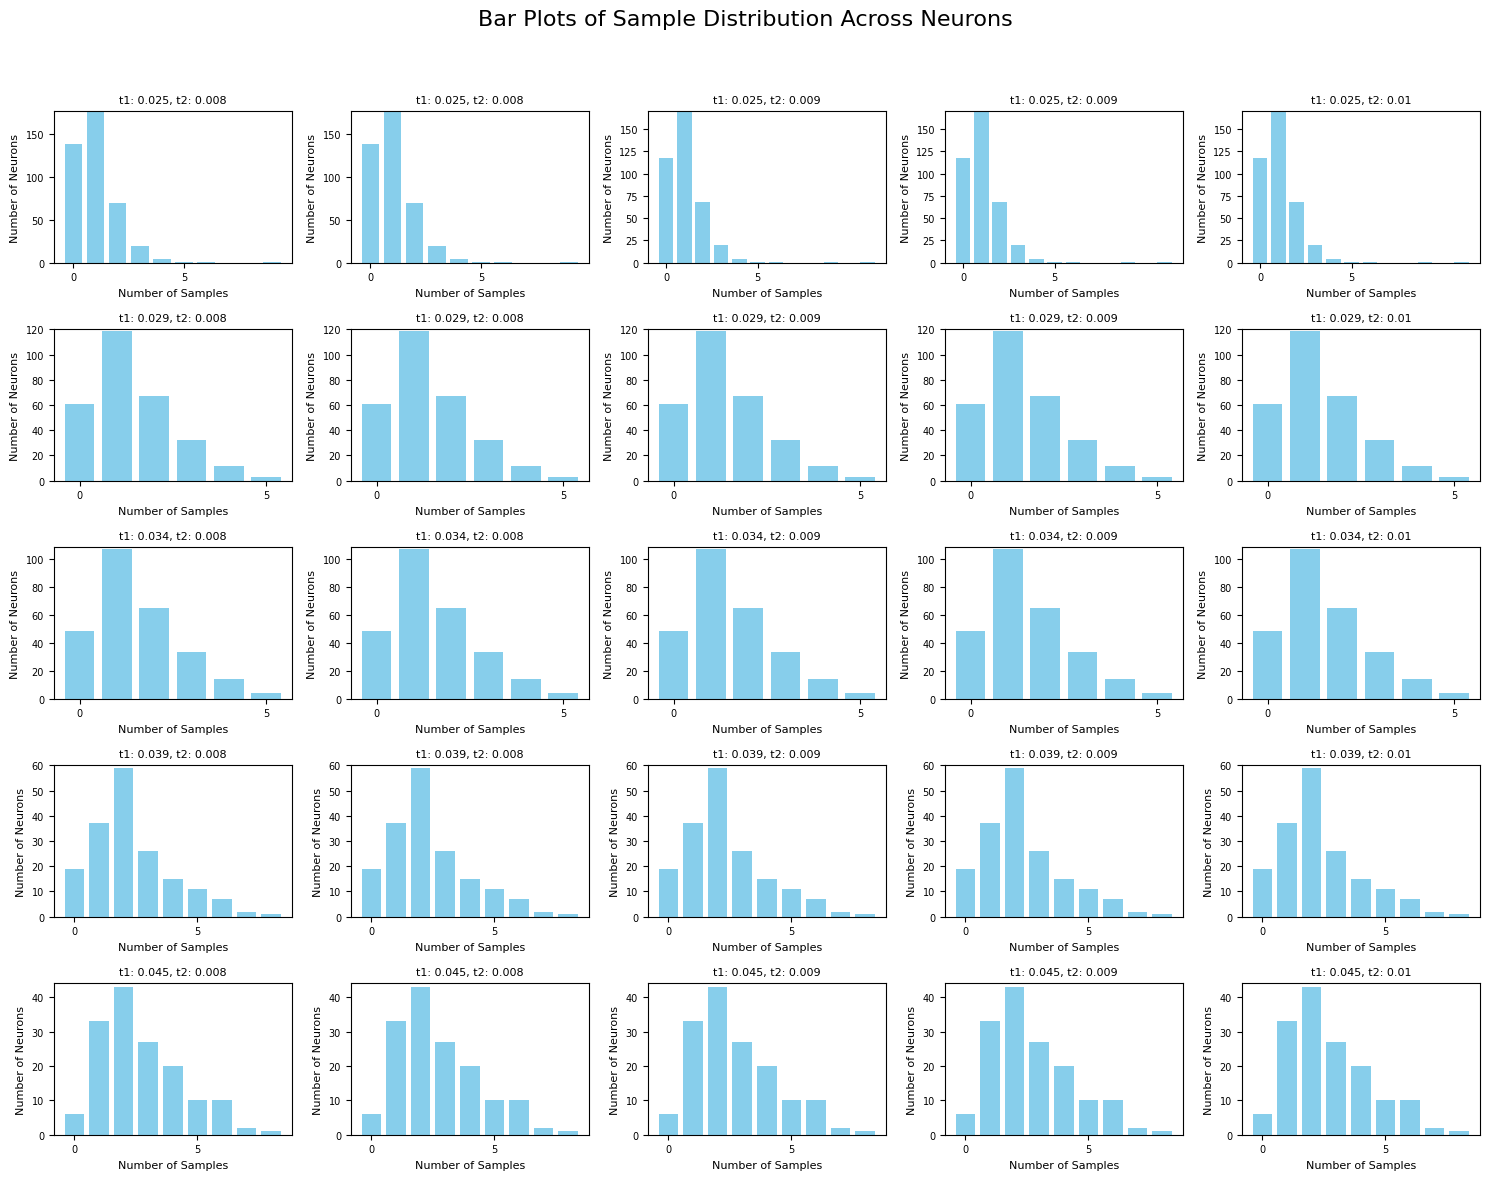

In [36]:
plot_bar_plots_for_sample_distribution(mapped_units, log_scale_t1, log_scale_t2)

In [37]:
metrics_for_zero_unit = calculate_leaf_neuron_metrics(train_mapped_zero_unit)
# Assuming leaf_metrics is the dictionary with metrics for all leaf neurons
data_mapped_counts = get_data_mapped_counts_list(metrics_for_zero_unit)
print("List of data_mapped_count values:", data_mapped_counts)

List of data_mapped_count values: [1, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 4, 3, 0, 2, 1, 2, 3, 4, 2, 0, 2, 0, 2, 1, 1, 2, 1, 3, 2, 3, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 3, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 0, 0, 1, 4, 3, 2, 1, 2, 2, 2, 2, 5, 2, 1, 1, 5, 4, 3, 1, 1, 0, 2, 2, 0, 2, 2, 2, 4, 1, 1, 3, 3, 1, 4, 2, 2, 2, 2, 3, 0, 1, 4, 2, 3, 1, 5, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 4, 3, 2, 2, 2, 1, 1, 2, 1, 2, 1, 4, 2, 3, 2, 1, 2, 3, 1, 3, 1, 0, 0, 2, 0, 1, 0, 3, 1, 1, 0, 2, 1, 1, 3, 4, 1, 1, 0, 2, 3, 1, 2, 3, 1, 1, 2, 1, 2, 1, 0, 1, 1, 3, 1, 1, 0, 1, 1, 2, 0, 1, 3, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 3, 2, 0, 1, 1, 2, 0, 0, 2, 3, 1, 0, 2, 1, 2, 2, 0, 1, 1, 0, 1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0, 3, 1, 0, 1, 1, 3, 1, 1, 0, 1, 3, 1, 2, 1, 0, 1, 1, 2, 3, 2, 4, 1, 4, 1, 4, 1, 0, 3, 5, 3, 0, 1, 2, 3, 1, 2, 4]


In [38]:
# Example usage: calculating neighborhood distances for the map at level 0 (zero_unit.child_map)
if zero_unit.child_map and hasattr(zero_unit.child_map, 'neurons'):
    neighborhood_distances_array = calculate_neighborhood_distances_for_map(zero_unit.child_map)
    print(neighborhood_distances_array)

[[3.48557767 3.0933244  3.15312534 4.67079816]
 [2.58972038 3.06162976 2.99528691 3.20677989]
 [2.91772353 2.71177859 2.66154103 2.70522268]
 [3.44623612 2.75453772 2.529599   2.79800429]]


In [39]:
from prada.plotting import print_tree_structure, get_neuron_by_position_list

In [40]:
print_tree_structure(train_mapped_zero_unit)

Level: 0, Position: (0, 0), Child map size: (4, 4), Number of data: 412
  |  Level: 1, Position: (0, 0), Child map size: (8, 2), Number of data: 12
  |    |  Level: 2, Position: (0, 0), Number of data: 1
  |    |  Level: 2, Position: (0, 1), Number of data: 0
  |    |  Level: 2, Position: (1, 0), Number of data: 0
  |    |  Level: 2, Position: (1, 1), Number of data: 0
  |    |  Level: 2, Position: (2, 0), Number of data: 1
  |    |  Level: 2, Position: (2, 1), Number of data: 1
  |    |  Level: 2, Position: (3, 0), Number of data: 1
  |    |  Level: 2, Position: (3, 1), Number of data: 1
  |    |  Level: 2, Position: (4, 0), Number of data: 0
  |    |  Level: 2, Position: (4, 1), Number of data: 3
  |    |  Level: 2, Position: (5, 0), Number of data: 0
  |    |  Level: 2, Position: (5, 1), Number of data: 0
  |    |  Level: 2, Position: (6, 0), Number of data: 2
  |    |  Level: 2, Position: (6, 1), Number of data: 0
  |    |  Level: 2, Position: (7, 0), Number of data: 1
  |    |  Le

In [41]:
neu = get_neuron_by_position_list(zero_unit, [(0, 0)]) # child neuron at position (0, 0).

In [42]:
def map_neuron_to_bmus(zero_unit, dataset_id_to_name):
    """
    Input: zero_unit, dataset_id_to_name
    Output: a dataframe with columns:
    Data Point Index	BMU Position	BMU Distance	Class Label	Class Name
    """
    data_info = []

    # Loop through the data indices stored in the root neuron
    for idx in zero_unit.input_indices:
        pos_list = [zero_unit.position]  # Store the position of the neuron in level 0
        current_neuron = zero_unit

        # Traverse down through the child maps if the neuron has children
        while hasattr(current_neuron, 'child_map') and current_neuron.child_map and current_neuron.child_map.neurons:
            # Find the winner neuron for this data point in the current neuron map
            winner_neurons, _ = current_neuron.child_map.winner_neuron(np.array([zero_unit.input_dataset[idx]]))
            current_neuron = winner_neurons[0]
            pos_list.append(current_neuron.position)

        # Collect BMU distance and class label (based on the neuron's input_labels)
        bmu_distance = current_neuron.activation(np.array([zero_unit.input_dataset[idx]]))[0]  # Get distance to the BMU

        # Retrieve the class label and name from the neuron itself
        if current_neuron.input_labels is not None and len(current_neuron.input_labels) > 0:
            class_label = current_neuron.input_labels[current_neuron.input_indices.tolist().index(idx)]
            class_name = dataset_id_to_name[class_label]
        else:
            class_label = "Unknown"
            class_name = "Unknown"

        data_info.append({
            'Data Point Index': idx,
            'BMU Position': pos_list,
            'BMU Distance': bmu_distance,
            'Class Label': class_label,  # Add class label (ID)
            'Class Name': class_name     # Add class name (translated from label)
        })

    # Return the data as a DataFrame
    df = pd.DataFrame(data_info)
    return df

In [43]:
df_bmus = map_neuron_to_bmus(test_mapped_zero_unit, dataset_id_to_name)
df_bmus

,Data Point Index,BMU Position,BMU Distance,Class Label,Class Name
0,0,"[(0, 0), (1, 3), (2, 5)]",1.461040,1,HR-Typical
1,1,"[(0, 0), (2, 3), (3, 0)]",0.545467,1,HR-Typical
2,2,"[(0, 0), (3, 2), (0, 7)]",1.121496,1,HR-Typical
3,3,"[(0, 0), (3, 2), (0, 6)]",0.299771,1,HR-Typical
4,4,"[(0, 0), (3, 0), (2, 1)]",2.484548,1,HR-Typical
...,...,...,...,...,...
232,232,"[(0, 0), (3, 0), (3, 1)]",1.335580,4,ASD
233,233,"[(0, 0), (3, 2), (0, 5)]",0.602444,4,ASD
234,234,"[(0, 0), (3, 3), (5, 1)]",1.777168,4,ASD
235,235,"[(0, 0), (3, 1), (5, 2)]",1.049645,4,ASD


In [44]:
dataset_counts = df_bmus['Class Name'].value_counts()
dataset_counts

Class Name
HR-Typical       106
ASD               65
Atypical          38
Down Syndrome     28
Name: count, dtype: int64

In [89]:
df_bmus_str = df_bmus.copy()
df_bmus_str['BMU Position'] = df_bmus['BMU Position'].apply(lambda x: str(x))

In [46]:
df_bmus_str # BMU Position is str, instead of list (unhashable type: 'list')

,Data Point Index,BMU Position,BMU Distance,Class Label,Class Name
0,0,"[(0, 0), (1, 3), (2, 5)]",1.461040,1,HR-Typical
1,1,"[(0, 0), (2, 3), (3, 0)]",0.545467,1,HR-Typical
2,2,"[(0, 0), (3, 2), (0, 7)]",1.121496,1,HR-Typical
3,3,"[(0, 0), (3, 2), (0, 6)]",0.299771,1,HR-Typical
4,4,"[(0, 0), (3, 0), (2, 1)]",2.484548,1,HR-Typical
...,...,...,...,...,...
232,232,"[(0, 0), (3, 0), (3, 1)]",1.335580,4,ASD
233,233,"[(0, 0), (3, 2), (0, 5)]",0.602444,4,ASD
234,234,"[(0, 0), (3, 3), (5, 1)]",1.777168,4,ASD
235,235,"[(0, 0), (3, 1), (5, 2)]",1.049645,4,ASD


In [47]:
bmucounts = df_bmus_str[['BMU Position', 'Class Name']].groupby(['BMU Position']).value_counts().reset_index(level=-1, name='count')
bmucounts

,Class Name,count
BMU Position,,
"[(0, 0), (0, 2), (3, 2)]",ASD,1
"[(0, 0), (0, 3), (0, 0)]",Down Syndrome,1
"[(0, 0), (0, 3), (0, 1)]",Atypical,2
"[(0, 0), (0, 3), (0, 1)]",HR-Typical,2
"[(0, 0), (0, 3), (1, 1)]",Atypical,1
...,...,...
"[(0, 0), (3, 3), (6, 1)]",Atypical,1
"[(0, 0), (3, 3), (7, 0)]",HR-Typical,2
"[(0, 0), (3, 3), (7, 0)]",ASD,1


In [48]:
from prada.plotting import plot_map_with_quad, plot_map_with_test_data, plot_map_with_test_data_significant_bmus, plot_map_with_test_data_markers, plot_map_with_asd_samples, plot_map_with_selected_asd_samples

In [ ]:
def plot1(zero_unit, dataset_id_to_name=dataset_id_to_name):
    if zero_unit.child_map and hasattr(zero_unit.child_map, 'neurons'):
        plot_map_with_quad(zero_unit.child_map, dataset_id_to_name)
    else:
        print("Neuron has NO child map")

def plot2(trained_zero_unit, test_zero_unit, dataset_id_to_name=dataset_id_to_name):
    if trained_zero_unit.child_map and hasattr(trained_zero_unit.child_map, 'neurons'):
        plot_map_with_test_data(trained_zero_unit.child_map, test_zero_unit.child_map, dataset_id_to_name)
    else:
        print("Neuron has NO child map")

def plot3(trained_zero_unit, test_zero_unit, dataset_id_to_name=dataset_id_to_name, percent_threshold=10):
    if trained_zero_unit.child_map and hasattr(trained_zero_unit.child_map, 'neurons'):
        plot_map_with_test_data_significant_bmus(trained_zero_unit.child_map, test_zero_unit.child_map, dataset_id_to_name, percent_threshold)
    else:
        print("Neuron has NO child map")

def plot4(trained_zero_unit, test_zero_unit, dataset_id_to_name=dataset_id_to_name, percent_threshold=10):
    if trained_zero_unit.child_map and hasattr(trained_zero_unit.child_map, 'neurons'):
        plot_map_with_test_data_markers(trained_zero_unit.child_map, test_zero_unit.child_map, dataset_id_to_name, percent_threshold)
    else:
        print("Neuron has NO child map")
        
def plot5(trained_zero_unit, test_zero_unit, dataset_id_to_name=dataset_id_to_name):
    if trained_zero_unit.child_map and hasattr(trained_zero_unit.child_map, 'neurons'):
        plot_map_with_asd_samples(trained_zero_unit.child_map, test_zero_unit.child_map, dataset_id_to_name)
    else:
        print("Neuron has NO child map")

def plot6(trained_zero_unit, test_zero_unit, dataset_id_to_name=dataset_id_to_name, key_list=key_list, marker_size=200):
    if trained_zero_unit.child_map and hasattr(trained_zero_unit.child_map, 'neurons'):
        plot_map_with_selected_asd_samples(trained_zero_unit.child_map, test_zero_unit.child_map, dataset_id_to_name, key_list, marker_size=marker_size)
    else:
        print("Neuron has NO child map")

In [ ]:
## Keep only the samples with identifiers in the key_list. We keep 55 of total 65 samples.
## (keeping samples having only ASD diagnosis).

key_list = [
    'IBIS160209','IBIS389521','IBIS107524','IBIS903923','IBIS152174','IBIS396346','IBIS460612','IBIS515353','IBIS680028','IBIS830319','IBIS569748',
    'IBIS108131','IBIS373485','IBIS845807','IBIS910593','IBIS919979','IBIS155712','IBIS929204','IBIS973338','IBIS174982','IBIS983222','IBIS230955',
    'IBIS988197','IBIS235108','IBIS988903','IBIS241033','IBIS291809','IBIS336576','IBIS389101','IBIS391729','IBIS402809','IBIS439857','IBIS447754',
    'IBIS456823','IBIS463809','IBIS482642','IBIS490878','IBIS544847','IBIS552855','IBIS553295','IBIS597653','IBIS603076','IBIS628043','IBIS638999',
    'IBIS641078','IBIS649998','IBIS784198','IBIS809318','IBIS816236','IBIS841812','IBIS930203','IBIS931343','IBIS943489','IBIS950194','IBIS963992'
        ]

In [51]:
len(key_list)

55

In [53]:
def get_and_plot_neuron_by_position_list(train_mapped_zero_unit,test_mapped_zero_unit, position_list, marker_size=200):
    neuron_tr = get_neuron_by_position_list(train_mapped_zero_unit, position_list)
    neuron_te = get_neuron_by_position_list(test_mapped_zero_unit, position_list)

    print(f"Neuron at: (0,0) {position_list} \n")    
    print("===> TRAIN tree structure:\n")
    print_tree_structure(train_mapped_zero_unit)
    plot1(neuron_tr)
    print("===> TEST tree structure:\n")
    print_tree_structure(test_mapped_zero_unit)
    plot2(neuron_tr,neuron_te)
    plot3(neuron_tr,neuron_te)
    plot4(neuron_tr,neuron_te)
    plot5(neuron_tr,neuron_te)
    plot6(neuron_tr,neuron_te, marker_size=marker_size)

### Plot trained GHSOM maps with samples.

Neuron at: (0,0) [] 

===> TRAIN tree structure:

Level: 0, Position: (0, 0), Child map size: (4, 4), Number of data: 412
  |  Level: 1, Position: (0, 0), Child map size: (8, 2), Number of data: 12
  |    |  Level: 2, Position: (0, 0), Number of data: 1
  |    |  Level: 2, Position: (0, 1), Number of data: 0
  |    |  Level: 2, Position: (1, 0), Number of data: 0
  |    |  Level: 2, Position: (1, 1), Number of data: 0
  |    |  Level: 2, Position: (2, 0), Number of data: 1
  |    |  Level: 2, Position: (2, 1), Number of data: 1
  |    |  Level: 2, Position: (3, 0), Number of data: 1
  |    |  Level: 2, Position: (3, 1), Number of data: 1
  |    |  Level: 2, Position: (4, 0), Number of data: 0
  |    |  Level: 2, Position: (4, 1), Number of data: 3
  |    |  Level: 2, Position: (5, 0), Number of data: 0
  |    |  Level: 2, Position: (5, 1), Number of data: 0
  |    |  Level: 2, Position: (6, 0), Number of data: 2
  |    |  Level: 2, Position: (6, 1), Number of data: 0
  |    |  Level: 2

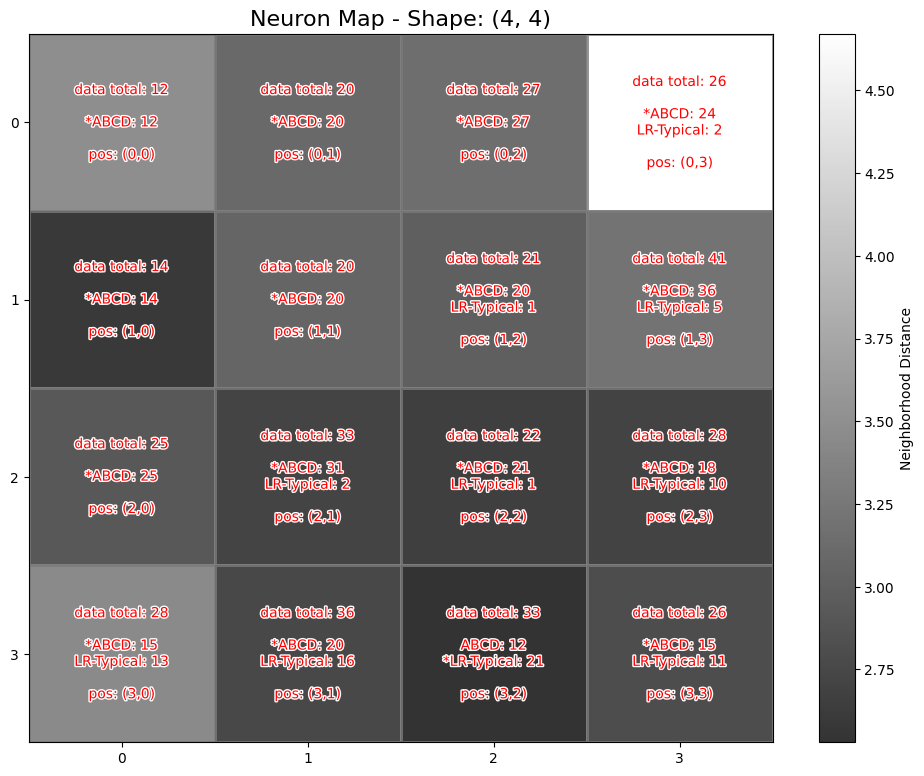

===> TEST tree structure:

Level: 0, Position: (0, 0), Child map size: (4, 4), Number of data: 237
  |  Level: 1, Position: (0, 0), Child map size: (8, 2), Number of data: 0
  |    |  Level: 2, Position: (0, 0), Number of data: 0
  |    |  Level: 2, Position: (0, 1), Number of data: 0
  |    |  Level: 2, Position: (1, 0), Number of data: 0
  |    |  Level: 2, Position: (1, 1), Number of data: 0
  |    |  Level: 2, Position: (2, 0), Number of data: 0
  |    |  Level: 2, Position: (2, 1), Number of data: 0
  |    |  Level: 2, Position: (3, 0), Number of data: 0
  |    |  Level: 2, Position: (3, 1), Number of data: 0
  |    |  Level: 2, Position: (4, 0), Number of data: 0
  |    |  Level: 2, Position: (4, 1), Number of data: 0
  |    |  Level: 2, Position: (5, 0), Number of data: 0
  |    |  Level: 2, Position: (5, 1), Number of data: 0
  |    |  Level: 2, Position: (6, 0), Number of data: 0
  |    |  Level: 2, Position: (6, 1), Number of data: 0
  |    |  Level: 2, Position: (7, 0), Numb

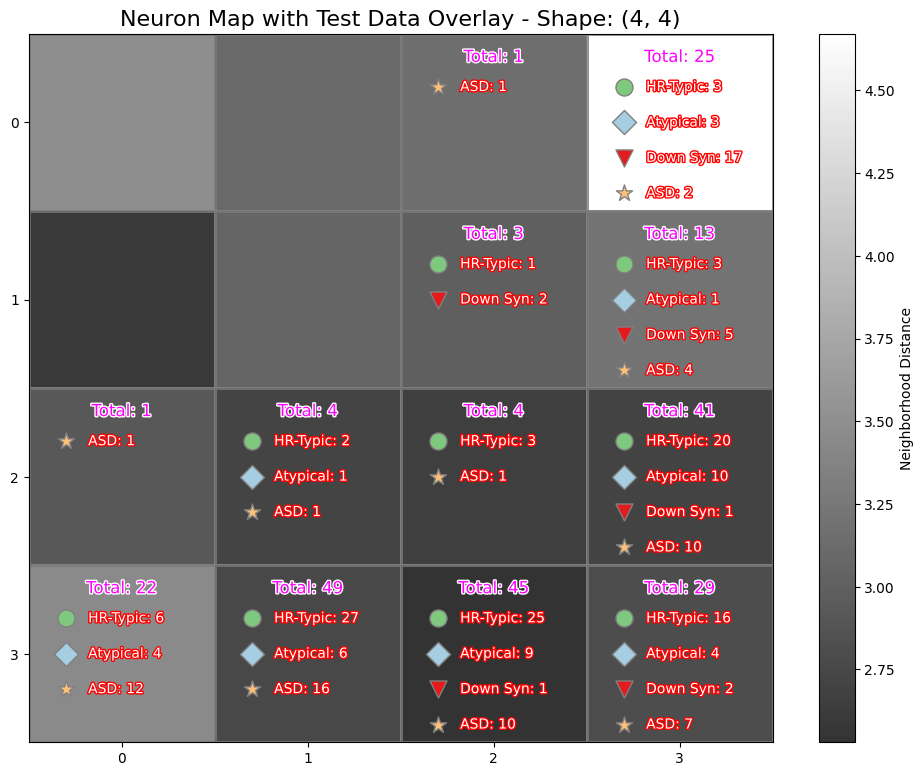

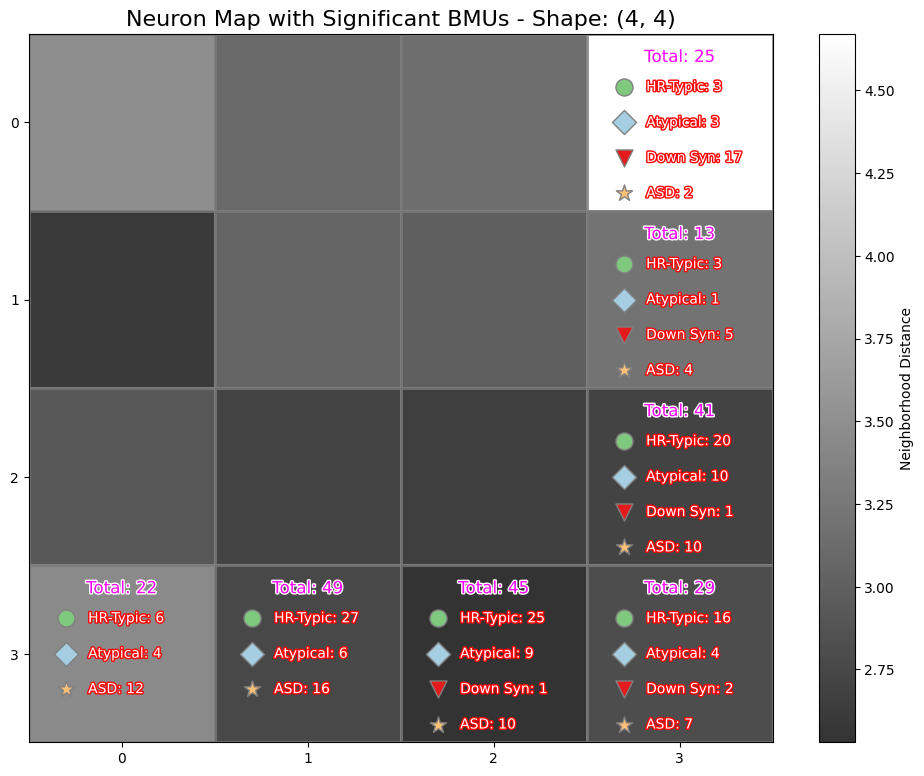

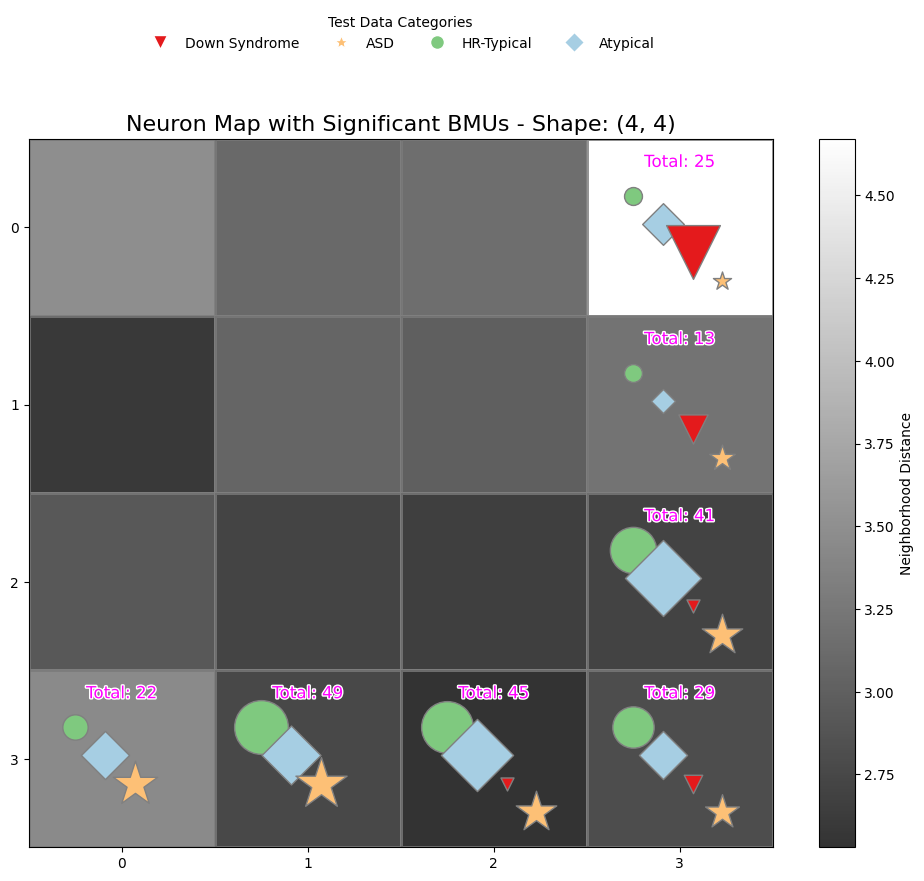

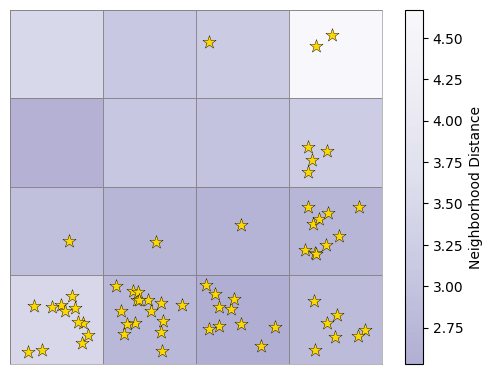

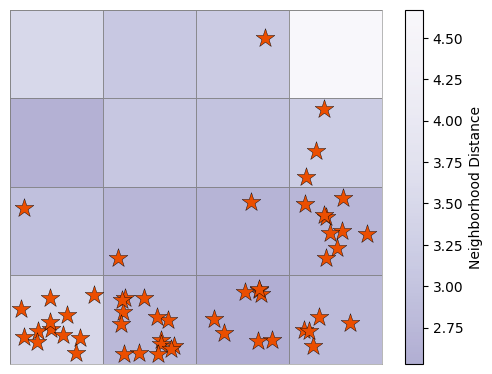

In [54]:
position_list = []

get_and_plot_neuron_by_position_list(train_mapped_zero_unit,test_mapped_zero_unit, position_list, marker_size=200)

In [55]:
def calculate_total_mapped_data(leaf_metrics):
    """
    Sum the 'data_mapped_count' from the leaf metrics to calculate the total number of mapped data points.
    
    :param leaf_metrics: Dictionary containing metrics for all leaf neurons
    :return: Total number of mapped data points
    """
    total_mapped_data = sum(metrics["data_mapped_count"] for metrics in leaf_metrics.values() if "data_mapped_count" in metrics)
    return total_mapped_data

total_mapped_data = calculate_total_mapped_data(metrics_for_zero_unit)
print("Total mapped data points:", total_mapped_data)

inlier_data.shape, total_mapped_data

Total mapped data points: 412


((412, 20), 412)

In [56]:
len(data_mapped_counts)

271

In [57]:
mapped_idx = get_neuron_by_position_list(test_mapped_zero_unit,[]).input_indices
len(mapped_idx), test_identifiers[mapped_idx]

(237,
 array(['IBIS530721', 'IBIS130523', 'IBIS548690', 'IBIS131614',
        'IBIS540777', 'IBIS136360', 'IBIS549587', 'IBIS136846',
        'IBIS565029', 'IBIS137726', 'IBIS568175', 'IBIS141335',
        'IBIS613004', 'IBIS144896', 'IBIS618875', 'IBIS145656',
        'IBIS621892', 'IBIS179886', 'IBIS636817', 'IBIS189601',
        'IBIS636881', 'IBIS191896', 'IBIS638943', 'IBIS213043',
        'IBIS650503', 'IBIS216279', 'IBIS658909', 'IBIS220411',
        'IBIS675255', 'IBIS220416', 'IBIS685724', 'IBIS221751',
        'IBIS693153', 'IBIS224012', 'IBIS710239', 'IBIS229701',
        'IBIS713824', 'IBIS232791', 'IBIS749359', 'IBIS235125',
        'IBIS763676', 'IBIS247315', 'IBIS769118', 'IBIS280066',
        'IBIS788407', 'IBIS300333', 'IBIS798424', 'IBIS301941',
        'IBIS802785', 'IBIS303247', 'IBIS806356', 'IBIS309070',
        'IBIS810313', 'IBIS323623', 'IBIS812952', 'IBIS336398',
        'IBIS822794', 'IBIS337032', 'IBIS823104', 'IBIS347302',
        'IBIS831855', 'IBIS360421'

In [58]:
mapped_labels = get_neuron_by_position_list(test_mapped_zero_unit,[]).input_labels
mapped_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [59]:
mapped_label_names = [dataset_id_to_name[i] for i in mapped_labels]
mapped_label_names

['HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typical',
 'HR-Typic

In [60]:
Data_cohort_VSA = pd.read_csv('spreadsheets/Data-cohort-VSA.csv')

In [61]:
Data_cohort_VSA.head()

,"VSA demographics,CandID","VSA-CVD demographics,CandID","VSA demographics,Cohort","VSA-CVD demographics,Cohort"
0,108131,108131,IBIS2 High Risk,IBIS2 High Risk
1,360421,.,IBIS2 High Risk,.
2,105477,.,DS SA,.
3,110925,.,DS SA,.
4,123451,.,DS SA,.


In [62]:
test_identifiers = pd.DataFrame(test_identifiers)

In [63]:
import pandas as pd

# Extract the candidate ID from 'test_keys' DataFrame by removing the 'IBIS' prefix
test_identifiers['CandID'] = test_identifiers[0].str.replace('IBIS', '')

# Create empty columns in Data_cohort_VSA for the test keys and labels
Data_cohort_VSA['Test_Key'] = None
Data_cohort_VSA['Mapped_Label'] = None

# Iterate through the test_keys dataframe and mapped_label_names to place values in Data_cohort_VSA
for index, (test_key, label_name) in enumerate(zip(test_identifiers[0], mapped_label_names)):
    # Get the corresponding candidate ID without the 'IBIS' prefix
    candidate_id = test_key.replace('IBIS', '')

    # Find the row in Data_cohort_VSA where the candidate ID is located in either of the two columns
    matching_row = Data_cohort_VSA[
        (Data_cohort_VSA['VSA demographics,CandID'] == candidate_id) | 
        (Data_cohort_VSA['VSA-CVD demographics,CandID'] == candidate_id)
    ]

    # If a match is found, place the test_key and label_name in the appropriate columns
    if not matching_row.empty:
        Data_cohort_VSA.loc[matching_row.index, 'Test_Key'] = test_key
        Data_cohort_VSA.loc[matching_row.index, 'Mapped_Label'] = label_name

In [64]:
# Add the Index column
Data_cohort_VSA['Index'] = range(1, len(Data_cohort_VSA) + 1)

# Move the 'Index' column to the first position
Data_cohort_VSA.insert(0, 'Index', Data_cohort_VSA.pop('Index'))

In [65]:
display_scrollable_dataframe_with_sticky_header(Data_cohort_VSA)

Index,"VSA demographics,CandID","VSA-CVD demographics,CandID","VSA demographics,Cohort","VSA-CVD demographics,Cohort",Test_Key,Mapped_Label
1,108131,108131,IBIS2 High Risk,IBIS2 High Risk,IBIS108131,ASD
2,360421,.,IBIS2 High Risk,.,IBIS360421,HR-Typical
3,105477,.,DS SA,.,IBIS105477,Down Syndrome
4,110925,.,DS SA,.,IBIS110925,ASD
5,123451,.,DS SA,.,IBIS123451,Down Syndrome
6,131087,.,DS SA,.,None,None
7,146443,.,DS SA,.,IBIS146443,Down Syndrome
8,160841,.,DS SA,.,None,None
9,187181,.,DS SA,.,None,None
10,241190,.,DS SA,.,None,None


In [66]:
def extract_data_for_specific_child_map_with_bmu_distances(neuron_with_child_map, dataset_id_to_name):
    """
    Extracts mapped positions, labels, indices, identifiers, label names, and BMU distances for samples
    in a specified child map, handling cases where certain neurons may lack input datasets.
    
    :param neuron_with_child_map: The neuron whose child map we want to inspect
    :param dataset_id_to_name: A dictionary mapping dataset IDs to their names
    :return: DataFrame with mapped positions, input labels, indices, identifiers, label names, and BMU distances
    """
    data = []

    # Traverse the neurons in the specified child map
    if hasattr(neuron_with_child_map, 'child_map') and neuron_with_child_map.child_map:
        for pos, child_neuron in neuron_with_child_map.child_map.neurons.items():
            if child_neuron.input_labels is not None and len(child_neuron.input_labels) > 0:
                # Collect the mapped sample data for each child neuron
                for i, label in enumerate(child_neuron.input_labels):
                    # Get the label name using the mapping
                    label_name = dataset_id_to_name[label] if label in dataset_id_to_name else "Unknown"
                    
                    # Calculate the BMU distance for the sample
                    sample_data = np.array([neuron_with_child_map.input_dataset[child_neuron.input_indices[i]]])
                    bmu_distance = child_neuron.activation(sample_data)[0]  # Calculate distance to the BMU

                    data.append({
                        'Input Index': child_neuron.input_indices[i] if child_neuron.input_indices is not None else None,
                        'Mapped Position': pos,
                        'Identifier': child_neuron.input_identifiers[i] if child_neuron.input_identifiers is not None else None,
                        'Input Label': label,
                        'Label Name': label_name,
                        'BMU Distance': bmu_distance
                    })
    return pd.DataFrame(data)

# Example usage: Define the mapping dictionary and extract data with BMU distances
child_map_data_table = extract_data_for_specific_child_map_with_bmu_distances(test_mapped_zero_unit, dataset_id_to_name)

# Display the table
display_scrollable_dataframe_with_sticky_header(child_map_data_table)

Input Index,Mapped Position,Identifier,Input Label,Label Name,BMU Distance
41,"(0, 3)",IBIS247315,1,HR-Typical,2.710514
81,"(0, 3)",IBIS476634,1,HR-Typical,1.526264
97,"(0, 3)",IBIS525057,1,HR-Typical,2.804807
112,"(0, 3)",IBIS214027,2,Atypical,1.043259
134,"(0, 3)",IBIS796006,2,Atypical,2.148146
136,"(0, 3)",IBIS822865,2,Atypical,2.444904
144,"(0, 3)",IBIS105477,3,Down Syndrome,7.966043
145,"(0, 3)",IBIS110925,3,Down Syndrome,6.583134
147,"(0, 3)",IBIS146443,3,Down Syndrome,4.251913
148,"(0, 3)",IBIS241887,3,Down Syndrome,6.141142


In [67]:
def extract_leaf_node_positions_with_bmu_distances(neuron_with_child_map, dataset_id_to_name):
    """
    Extracts mapped positions for samples only mapped to leaf nodes, 
    along with their labels, indices, identifiers, label names, and BMU distances.
    
    :param neuron_with_child_map: The neuron whose child map we want to inspect
    :param dataset_id_to_name: A dictionary mapping dataset IDs to their names
    :return: DataFrame with position lists for samples mapped to leaf nodes, 
             along with input labels, indices, identifiers, label names, and BMU distances
    """
    data = []

    # Recursive function to traverse the tree and gather mapped positions
    def traverse_and_collect_positions(neuron, position_list):
        if not hasattr(neuron, 'child_map') or not neuron.child_map:
            # This neuron is a leaf node
            if neuron.input_labels is not None and len(neuron.input_labels) > 0:
                # Collect data for each sample mapped to this leaf node
                for i, label in enumerate(neuron.input_labels):
                    # Get the label name using the mapping
                    label_name = dataset_id_to_name[label] if label in dataset_id_to_name else "Unknown"

                    # Calculate the BMU distance for the sample
                    sample_data = np.array([neuron_with_child_map.input_dataset[neuron.input_indices[i]]])
                    bmu_distance = neuron.activation(sample_data)[0]  # Calculate distance to the BMU

                    data.append({
                        'Input Index': neuron.input_indices[i] if neuron.input_indices is not None else None,
                        'Position List': position_list,
                        'Identifier': neuron.input_identifiers[i] if neuron.input_identifiers is not None else None,
                        'Input Label': label,
                        'Label Name': label_name,
                        'BMU Distance': bmu_distance
                    })
        else:
            # This neuron has a child map, so we continue traversing
            for pos, child_neuron in neuron.child_map.neurons.items():
                traverse_and_collect_positions(child_neuron, position_list + [pos])

    # Start traversing from the given neuron with an empty position list
    traverse_and_collect_positions(neuron_with_child_map, [])

    return pd.DataFrame(data)

# Example usage: Define the mapping dictionary and extract leaf node positions with BMU distances
leaf_node_positions_table = extract_leaf_node_positions_with_bmu_distances(test_mapped_zero_unit, dataset_id_to_name)

# Display the table
display_scrollable_dataframe_with_sticky_header(leaf_node_positions_table)

Input Index,Position List,Identifier,Input Label,Label Name,BMU Distance
169,"[(0, 3), (0, 0)]",IBIS965321,3,Down Syndrome,2.441061
81,"[(0, 3), (0, 1)]",IBIS476634,1,HR-Typical,0.822437
97,"[(0, 3), (0, 1)]",IBIS525057,1,HR-Typical,2.245883
134,"[(0, 3), (0, 1)]",IBIS796006,2,Atypical,1.694780
136,"[(0, 3), (0, 1)]",IBIS822865,2,Atypical,1.765750
112,"[(0, 3), (1, 1)]",IBIS214027,2,Atypical,1.364452
144,"[(0, 3), (6, 0)]",IBIS105477,3,Down Syndrome,3.852409
145,"[(0, 3), (6, 0)]",IBIS110925,3,Down Syndrome,2.409018
148,"[(0, 3), (6, 0)]",IBIS241887,3,Down Syndrome,1.609941
155,"[(0, 3), (6, 0)]",IBIS514978,3,Down Syndrome,2.516456


In [68]:
leaf_node_positions_table_ds = leaf_node_positions_table[leaf_node_positions_table['Label Name']=='Down Syndrome']

In [69]:
display_scrollable_dataframe_with_sticky_header(leaf_node_positions_table_ds)
leaf_node_positions_table_ds.shape

Input Index,Position List,Identifier,Input Label,Label Name,BMU Distance
169,"[(0, 3), (0, 0)]",IBIS965321,3,Down Syndrome,2.441061
144,"[(0, 3), (6, 0)]",IBIS105477,3,Down Syndrome,3.852409
145,"[(0, 3), (6, 0)]",IBIS110925,3,Down Syndrome,2.409018
148,"[(0, 3), (6, 0)]",IBIS241887,3,Down Syndrome,1.609941
155,"[(0, 3), (6, 0)]",IBIS514978,3,Down Syndrome,2.516456
156,"[(0, 3), (6, 0)]",IBIS546895,3,Down Syndrome,2.660098
158,"[(0, 3), (6, 0)]",IBIS615948,3,Down Syndrome,7.508757
159,"[(0, 3), (6, 0)]",IBIS688878,3,Down Syndrome,2.215053
161,"[(0, 3), (6, 0)]",IBIS718082,3,Down Syndrome,2.631709
163,"[(0, 3), (6, 0)]",IBIS767531,3,Down Syndrome,2.056350


(28, 6)

In [70]:
leaf_node_positions_table_asd = leaf_node_positions_table[leaf_node_positions_table['Label Name']=='ASD']

In [71]:
display_scrollable_dataframe_with_sticky_header(leaf_node_positions_table_asd)
leaf_node_positions_table_asd.shape

Input Index,Position List,Identifier,Input Label,Label Name,BMU Distance
177,"[(0, 3), (6, 0)]",IBIS110925,4,ASD,2.409018
222,"[(0, 3), (6, 0)]",IBIS688878,4,ASD,2.215053
183,"[(0, 2), (3, 2)]",IBIS160209,4,ASD,1.386925
209,"[(3, 0), (1, 0)]",IBIS544847,4,ASD,1.605376
230,"[(3, 0), (1, 1)]",IBIS841812,4,ASD,2.399711
218,"[(3, 0), (2, 1)]",IBIS638999,4,ASD,1.358328
212,"[(3, 0), (5, 1)]",IBIS569748,4,ASD,3.559591
219,"[(3, 0), (4, 0)]",IBIS641078,4,ASD,1.734443
178,"[(3, 0), (4, 1)]",IBIS910593,4,ASD,1.452471
194,"[(3, 0), (4, 1)]",IBIS373485,4,ASD,0.928345


(65, 6)

In [72]:
## Save the leaf node positions table to a CSV file along with the identifiers and bmus.
# leaf_node_positions_table_asd.to_csv('ghsom_outputs/bmus/asd_prototypes_ghsom_4x4_leaf_v08_hier.csv')

In [73]:
# if you want to work with IBIS-DS samples.
# leaf_node_positions_table_ds.to_csv('ghsom_outputs/bmus/ds_prototypes_ghsom_4x4_leaf_v08_hier.csv')

In [74]:
def convert_mapped_position_to_indices(df, col_name):
    """
    Converts the values in the 'Mapped Position' column to unique integer indices.
    
    :param df: The DataFrame with a 'Mapped Position' column
    :return: The modified DataFrame with 'Mapped Position' converted to unique integers
    """
    # Create a mapping of unique 'Mapped Position' values to unique integer indices
    unique_positions = df[col_name].unique()
    position_to_index = {pos: idx for idx, pos in enumerate(unique_positions)}

    # Apply the mapping to the 'Mapped Position' column
    df[col_name] = df[col_name].map(position_to_index)

    return df

# Example usage
# Assuming child_map_data_table is your DataFrame
child_map_data_table_ = convert_mapped_position_to_indices(child_map_data_table, 'Mapped Position')

# Display the modified table
child_map_data_table_

,Input Index,Mapped Position,Identifier,Input Label,Label Name,BMU Distance
0,41,0,IBIS247315,1,HR-Typical,2.710514
1,81,0,IBIS476634,1,HR-Typical,1.526264
2,97,0,IBIS525057,1,HR-Typical,2.804807
3,112,0,IBIS214027,2,Atypical,1.043259
4,134,0,IBIS796006,2,Atypical,2.148146
...,...,...,...,...,...,...
232,170,11,IBIS976405,3,Down Syndrome,1.932469
233,174,11,IBIS903923,4,ASD,2.242037
234,196,11,IBIS389521,4,ASD,1.719558
235,208,11,IBIS515353,4,ASD,1.794249


In [75]:
# Create a new DataFrame with the 'Position List' column converted to strings
leaf_node_positions_table_ds_str = leaf_node_positions_table_ds.copy()
leaf_node_positions_table_ds_str['Position List'] = leaf_node_positions_table_ds['Position List'].astype(str)
leaf_node_positions_table_ds_ = convert_mapped_position_to_indices(leaf_node_positions_table_ds_str, 'Position List')
display_scrollable_dataframe_with_sticky_header(leaf_node_positions_table_ds_)
leaf_node_positions_table_ds_.shape

Input Index,Position List,Identifier,Input Label,Label Name,BMU Distance
169,0,IBIS965321,3,Down Syndrome,2.441061
144,1,IBIS105477,3,Down Syndrome,3.852409
145,1,IBIS110925,3,Down Syndrome,2.409018
148,1,IBIS241887,3,Down Syndrome,1.609941
155,1,IBIS514978,3,Down Syndrome,2.516456
156,1,IBIS546895,3,Down Syndrome,2.660098
158,1,IBIS615948,3,Down Syndrome,7.508757
159,1,IBIS688878,3,Down Syndrome,2.215053
161,1,IBIS718082,3,Down Syndrome,2.631709
163,1,IBIS767531,3,Down Syndrome,2.056350


(28, 6)

In [76]:
# Create a new DataFrame with the 'Position List' column converted to strings
leaf_node_positions_table_asd_str = leaf_node_positions_table_asd.copy()
leaf_node_positions_table_asd_str['Position List'] = leaf_node_positions_table_asd['Position List'].astype(str)
leaf_node_positions_table_asd_ = convert_mapped_position_to_indices(leaf_node_positions_table_asd_str, 'Position List')
display_scrollable_dataframe_with_sticky_header(leaf_node_positions_table_asd_)
leaf_node_positions_table_asd_.shape

Input Index,Position List,Identifier,Input Label,Label Name,BMU Distance
177,0,IBIS110925,4,ASD,2.409018
222,0,IBIS688878,4,ASD,2.215053
183,1,IBIS160209,4,ASD,1.386925
209,2,IBIS544847,4,ASD,1.605376
230,3,IBIS841812,4,ASD,2.399711
218,4,IBIS638999,4,ASD,1.358328
212,5,IBIS569748,4,ASD,3.559591
219,6,IBIS641078,4,ASD,1.734443
178,7,IBIS910593,4,ASD,1.452471
194,7,IBIS373485,4,ASD,0.928345


(65, 6)

In [77]:
def filter_and_create_new_dataframe(df, label_name, col_name):
    """
    Creates a new DataFrame with only 'Mapped Position' and 'Identifier' columns,
    filtered by the specified label name.
    
    :param df: The original DataFrame
    :param label_name: The label name to filter by (e.g., "Down Syndrome")
    :return: A new filtered DataFrame with 'Mapped Position' and 'Identifier' columns
    """
    # Filter the DataFrame by the specified label name
    filtered_df = df[df['Label Name'] == label_name]

    # Select only 'Mapped Position' and 'Identifier' columns
    new_df = filtered_df[[col_name, 'Identifier']].copy()

    return new_df

# Assuming child_map_data_table is your original DataFrame
ds_prototypes_df = filter_and_create_new_dataframe(child_map_data_table_, "Down Syndrome", 'Mapped Position')

# Display the new DataFrame
ds_prototypes_df

,Mapped Position,Identifier
6,0,IBIS105477
7,0,IBIS110925
8,0,IBIS146443
9,0,IBIS241887
10,0,IBIS270140
11,0,IBIS509327
12,0,IBIS514978
13,0,IBIS546895
14,0,IBIS615948
15,0,IBIS688878


In [78]:
# Assuming child_map_data_table is your original DataFrame
asd_prototypes_df = filter_and_create_new_dataframe(child_map_data_table_, "ASD", 'Mapped Position')

# Display the new DataFrame
asd_prototypes_df

,Mapped Position,Identifier
23,0,IBIS110925
24,0,IBIS688878
25,1,IBIS160209
36,2,IBIS910593
37,2,IBIS155712
...,...,...
220,9,IBIS830319
233,11,IBIS903923
234,11,IBIS389521
235,11,IBIS515353


In [79]:
asd_prototypes_df_55 = asd_prototypes_df[asd_prototypes_df['Identifier'].isin(key_list)]
asd_prototypes_df_55, asd_prototypes_df_55.shape

(     Mapped Position  Identifier
 25                 1  IBIS160209
 36                 2  IBIS910593
 37                 2  IBIS155712
 38                 2  IBIS336576
 39                 2  IBIS373485
 40                 2  IBIS389101
 41                 2  IBIS490878
 42                 2  IBIS544847
 43                 2  IBIS569748
 44                 2  IBIS638999
 45                 2  IBIS641078
 46                 2  IBIS841812
 47                 2  IBIS931343
 81                 3  IBIS108131
 82                 3  IBIS174982
 83                 3  IBIS983222
 84                 3  IBIS230955
 85                 3  IBIS241033
 86                 3  IBIS439857
 87                 3  IBIS447754
 88                 3  IBIS463809
 90                 3  IBIS603076
 91                 3  IBIS628043
 92                 3  IBIS784198
 94                 3  IBIS816236
 95                 3  IBIS930203
 96                 3  IBIS950194
 132                4  IBIS919979
 133          

In [80]:
# Group by 'Mapped Position' and count the number of samples in each position
mapped_position_counts = asd_prototypes_df_55.groupby('Mapped Position').size().reset_index(name='Sample Count')

# Sort by sample count in descending order
mapped_position_counts = mapped_position_counts.sort_values(by='Sample Count', ascending=False)

# Display the new DataFrame
mapped_position_counts

,Mapped Position,Sample Count
2,3,14
1,2,12
8,9,9
3,4,8
4,5,5
9,11,3
0,1,1
5,6,1
6,7,1
7,8,1


In [81]:
ds_prototypes_df_leaf = filter_and_create_new_dataframe(leaf_node_positions_table_ds_, "Down Syndrome", "Position List")
ds_prototypes_df_leaf

,Position List,Identifier
0,0,IBIS965321
6,1,IBIS105477
7,1,IBIS110925
8,1,IBIS241887
9,1,IBIS514978
10,1,IBIS546895
11,1,IBIS615948
12,1,IBIS688878
13,1,IBIS718082
14,1,IBIS767531


In [82]:
asd_prototypes_df_leaf = filter_and_create_new_dataframe(leaf_node_positions_table_asd_, "ASD", "Position List")
asd_prototypes_df_leaf

,Position List,Identifier
15,0,IBIS110925
16,0,IBIS688878
25,1,IBIS160209
26,2,IBIS544847
27,3,IBIS841812
...,...,...
220,39,IBIS152174
224,40,IBIS389521
234,41,IBIS903923
235,41,IBIS515353


In [83]:
ds_prototypes_df_ = ds_prototypes_df.rename(columns={'Mapped Position': 'bmu', 'Identifier': 'ID'})
ds_prototypes_df_leaf_ = ds_prototypes_df_leaf.rename(columns={'Position List': 'bmu', 'Identifier': 'ID'})

In [84]:
asd_prototypes_df_ = asd_prototypes_df.rename(columns={'Mapped Position': 'bmu', 'Identifier': 'ID'})
asd_prototypes_df_leaf_ = asd_prototypes_df_leaf.rename(columns={'Position List': 'bmu', 'Identifier': 'ID'})

In [85]:
# SAVE
#ds_prototypes_df_.to_csv('ghsom_outputs/bmus/ds_prototypes_ghsom_4x4_parent_v08.csv', index=False)
#ds_prototypes_df_leaf_.to_csv('ghsom_outputs/bmus/ds_prototypes_ghsom_4x4_leaf_v08.csv', index=False)

In [86]:
# SAVE
# asd_prototypes_df_.to_csv('ghsom_outputs/bmus/asd_prototypes_ghsom_4x4_parent_v08.csv', index=False)
# asd_prototypes_df_leaf_.to_csv('ghsom_outputs/bmus/asd_prototypes_ghsom_4x4_leaf_v08.csv', index=False)

Neuron at: (0,0) [] 

===> TRAIN tree structure:

Level: 0, Position: (0, 0), Child map size: (4, 4), Number of data: 412
  |  Level: 1, Position: (0, 0), Child map size: (8, 2), Number of data: 12
  |    |  Level: 2, Position: (0, 0), Number of data: 1
  |    |  Level: 2, Position: (0, 1), Number of data: 0
  |    |  Level: 2, Position: (1, 0), Number of data: 0
  |    |  Level: 2, Position: (1, 1), Number of data: 0
  |    |  Level: 2, Position: (2, 0), Number of data: 1
  |    |  Level: 2, Position: (2, 1), Number of data: 1
  |    |  Level: 2, Position: (3, 0), Number of data: 1
  |    |  Level: 2, Position: (3, 1), Number of data: 1
  |    |  Level: 2, Position: (4, 0), Number of data: 0
  |    |  Level: 2, Position: (4, 1), Number of data: 3
  |    |  Level: 2, Position: (5, 0), Number of data: 0
  |    |  Level: 2, Position: (5, 1), Number of data: 0
  |    |  Level: 2, Position: (6, 0), Number of data: 2
  |    |  Level: 2, Position: (6, 1), Number of data: 0
  |    |  Level: 2

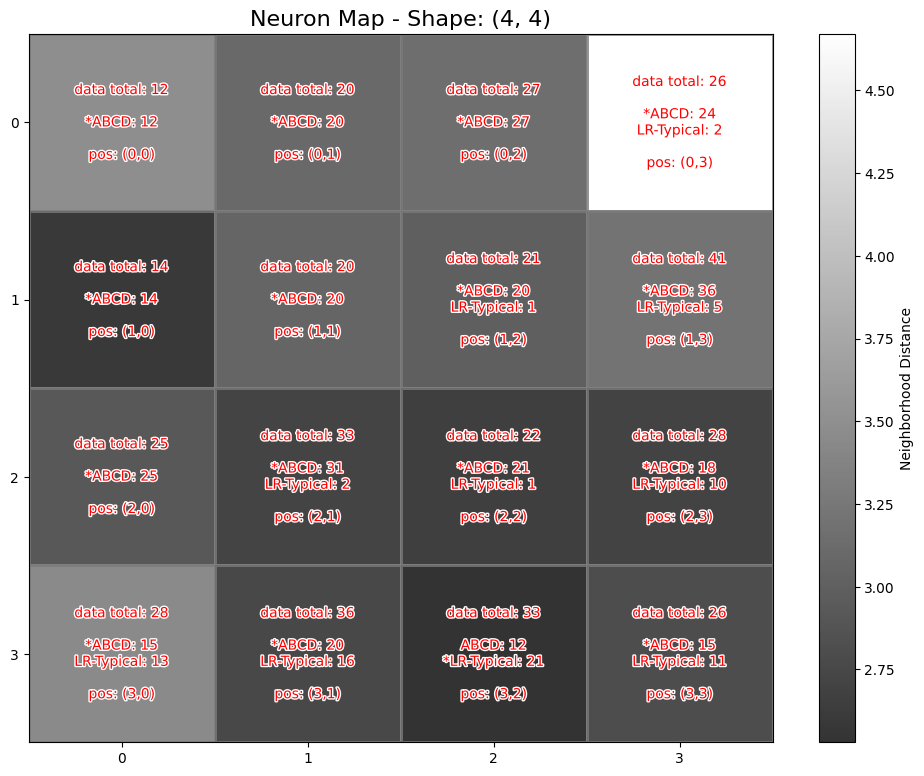

===> TEST tree structure:

Level: 0, Position: (0, 0), Child map size: (4, 4), Number of data: 237
  |  Level: 1, Position: (0, 0), Child map size: (8, 2), Number of data: 0
  |    |  Level: 2, Position: (0, 0), Number of data: 0
  |    |  Level: 2, Position: (0, 1), Number of data: 0
  |    |  Level: 2, Position: (1, 0), Number of data: 0
  |    |  Level: 2, Position: (1, 1), Number of data: 0
  |    |  Level: 2, Position: (2, 0), Number of data: 0
  |    |  Level: 2, Position: (2, 1), Number of data: 0
  |    |  Level: 2, Position: (3, 0), Number of data: 0
  |    |  Level: 2, Position: (3, 1), Number of data: 0
  |    |  Level: 2, Position: (4, 0), Number of data: 0
  |    |  Level: 2, Position: (4, 1), Number of data: 0
  |    |  Level: 2, Position: (5, 0), Number of data: 0
  |    |  Level: 2, Position: (5, 1), Number of data: 0
  |    |  Level: 2, Position: (6, 0), Number of data: 0
  |    |  Level: 2, Position: (6, 1), Number of data: 0
  |    |  Level: 2, Position: (7, 0), Numb

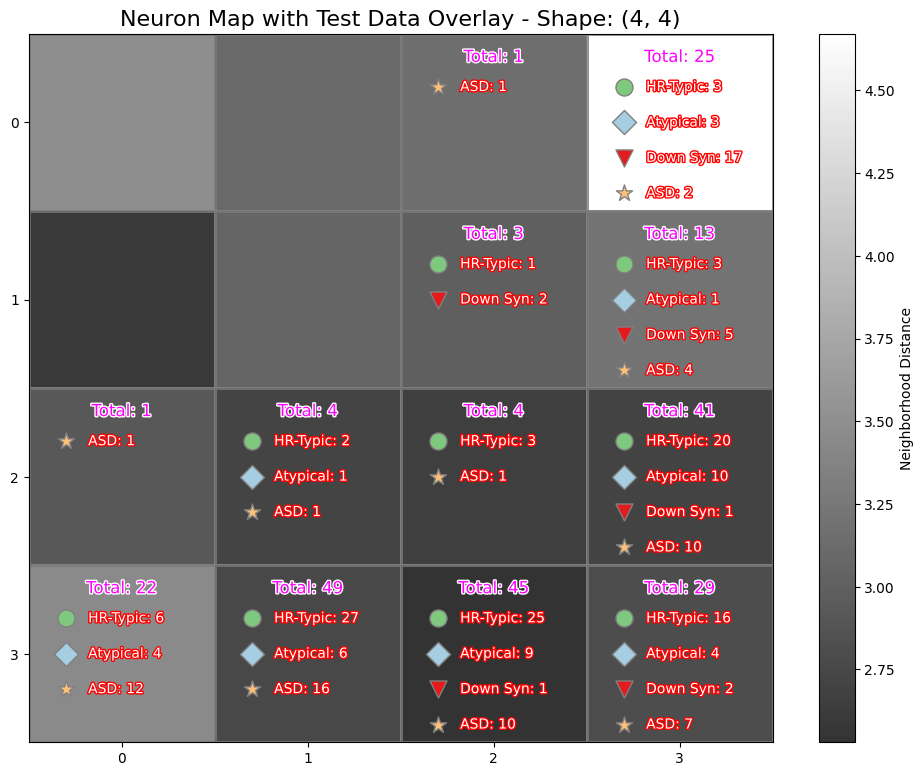

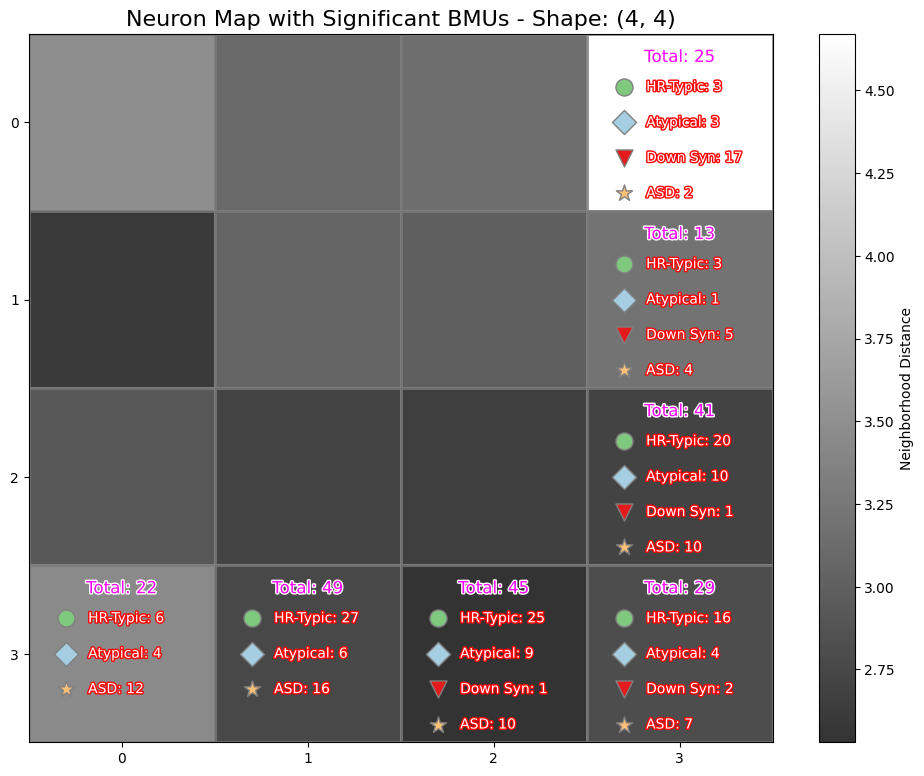

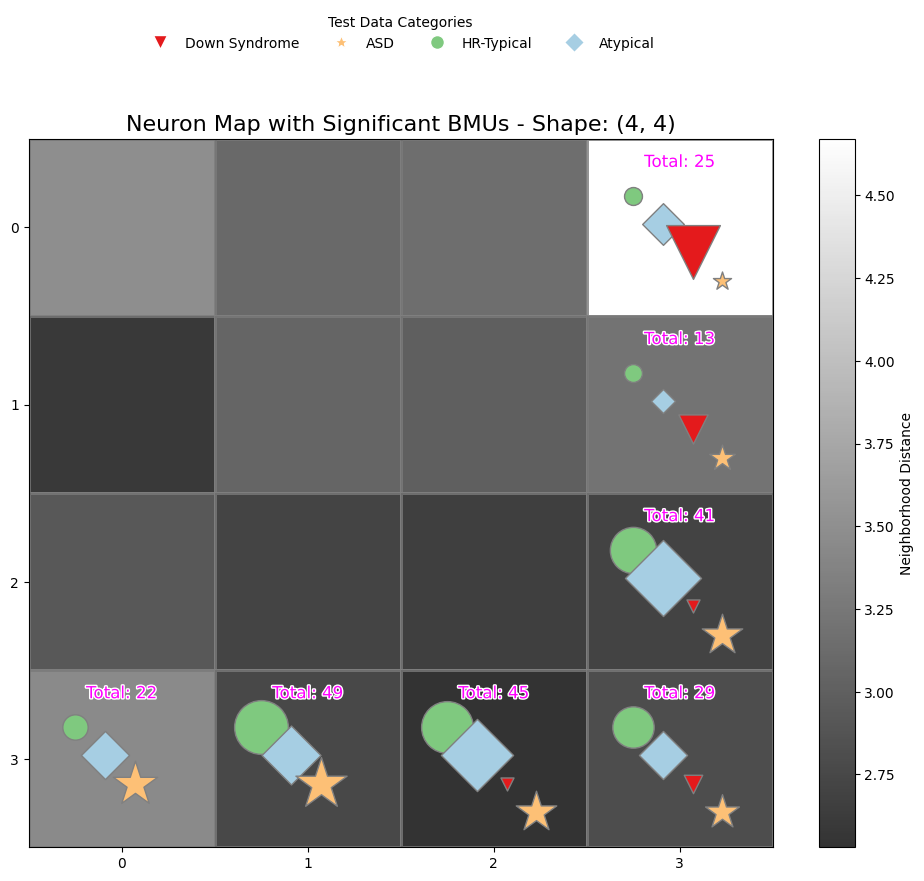

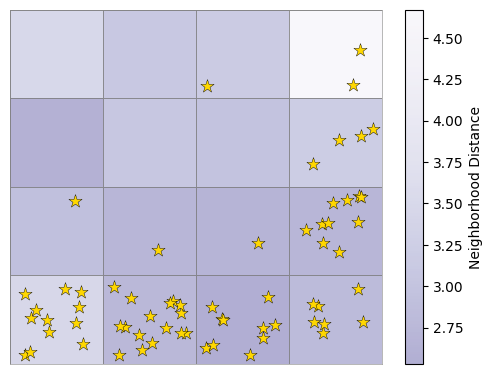

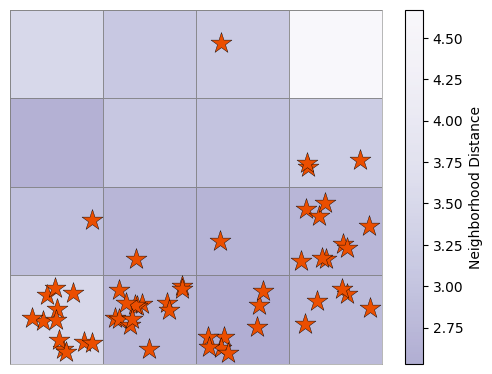

In [87]:
position_list = []

get_and_plot_neuron_by_position_list(train_mapped_zero_unit,test_mapped_zero_unit, position_list, marker_size=250)

Neuron at: (0,0) [(2, 3)] 

===> TRAIN tree structure:

Level: 0, Position: (0, 0), Child map size: (4, 4), Number of data: 412
  |  Level: 1, Position: (0, 0), Child map size: (8, 2), Number of data: 12
  |    |  Level: 2, Position: (0, 0), Number of data: 1
  |    |  Level: 2, Position: (0, 1), Number of data: 0
  |    |  Level: 2, Position: (1, 0), Number of data: 0
  |    |  Level: 2, Position: (1, 1), Number of data: 0
  |    |  Level: 2, Position: (2, 0), Number of data: 1
  |    |  Level: 2, Position: (2, 1), Number of data: 1
  |    |  Level: 2, Position: (3, 0), Number of data: 1
  |    |  Level: 2, Position: (3, 1), Number of data: 1
  |    |  Level: 2, Position: (4, 0), Number of data: 0
  |    |  Level: 2, Position: (4, 1), Number of data: 3
  |    |  Level: 2, Position: (5, 0), Number of data: 0
  |    |  Level: 2, Position: (5, 1), Number of data: 0
  |    |  Level: 2, Position: (6, 0), Number of data: 2
  |    |  Level: 2, Position: (6, 1), Number of data: 0
  |    |  Le

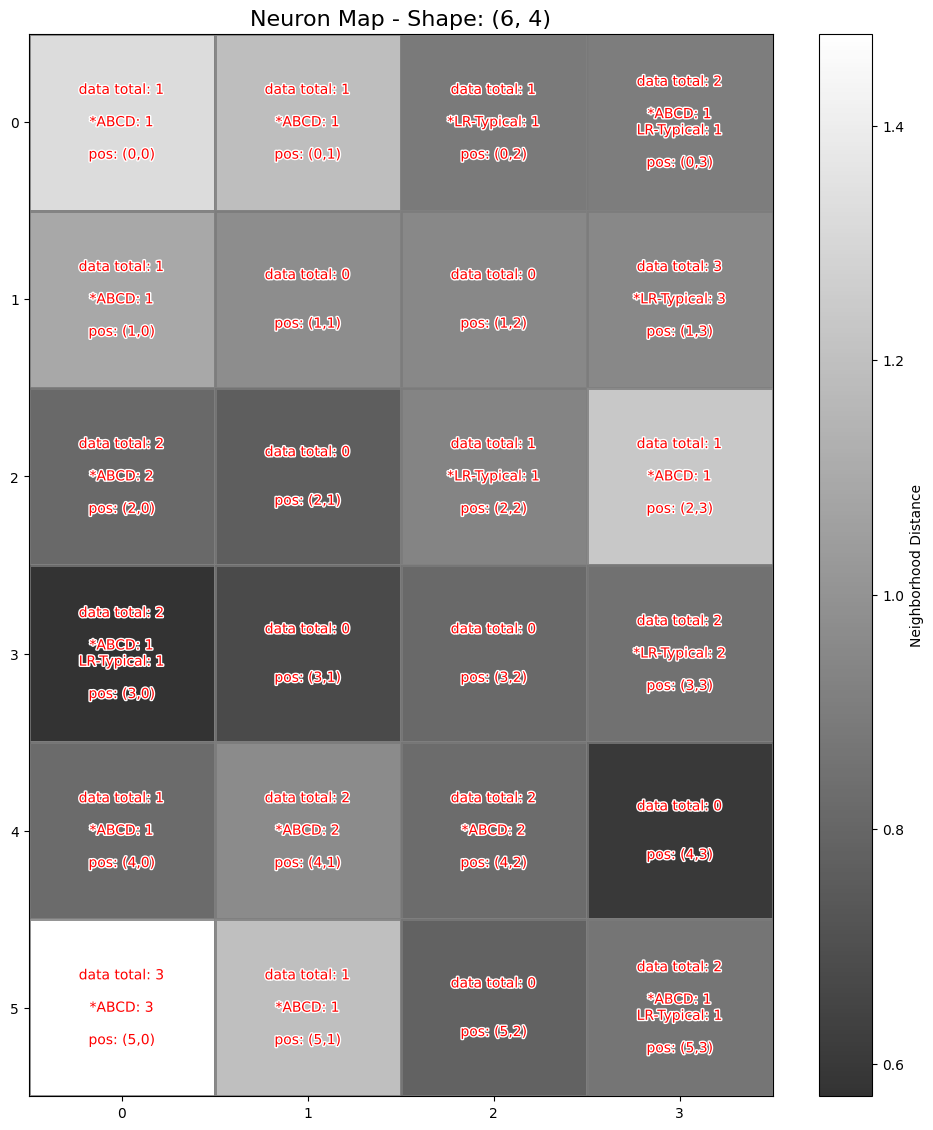

===> TEST tree structure:

Level: 0, Position: (0, 0), Child map size: (4, 4), Number of data: 237
  |  Level: 1, Position: (0, 0), Child map size: (8, 2), Number of data: 0
  |    |  Level: 2, Position: (0, 0), Number of data: 0
  |    |  Level: 2, Position: (0, 1), Number of data: 0
  |    |  Level: 2, Position: (1, 0), Number of data: 0
  |    |  Level: 2, Position: (1, 1), Number of data: 0
  |    |  Level: 2, Position: (2, 0), Number of data: 0
  |    |  Level: 2, Position: (2, 1), Number of data: 0
  |    |  Level: 2, Position: (3, 0), Number of data: 0
  |    |  Level: 2, Position: (3, 1), Number of data: 0
  |    |  Level: 2, Position: (4, 0), Number of data: 0
  |    |  Level: 2, Position: (4, 1), Number of data: 0
  |    |  Level: 2, Position: (5, 0), Number of data: 0
  |    |  Level: 2, Position: (5, 1), Number of data: 0
  |    |  Level: 2, Position: (6, 0), Number of data: 0
  |    |  Level: 2, Position: (6, 1), Number of data: 0
  |    |  Level: 2, Position: (7, 0), Numb

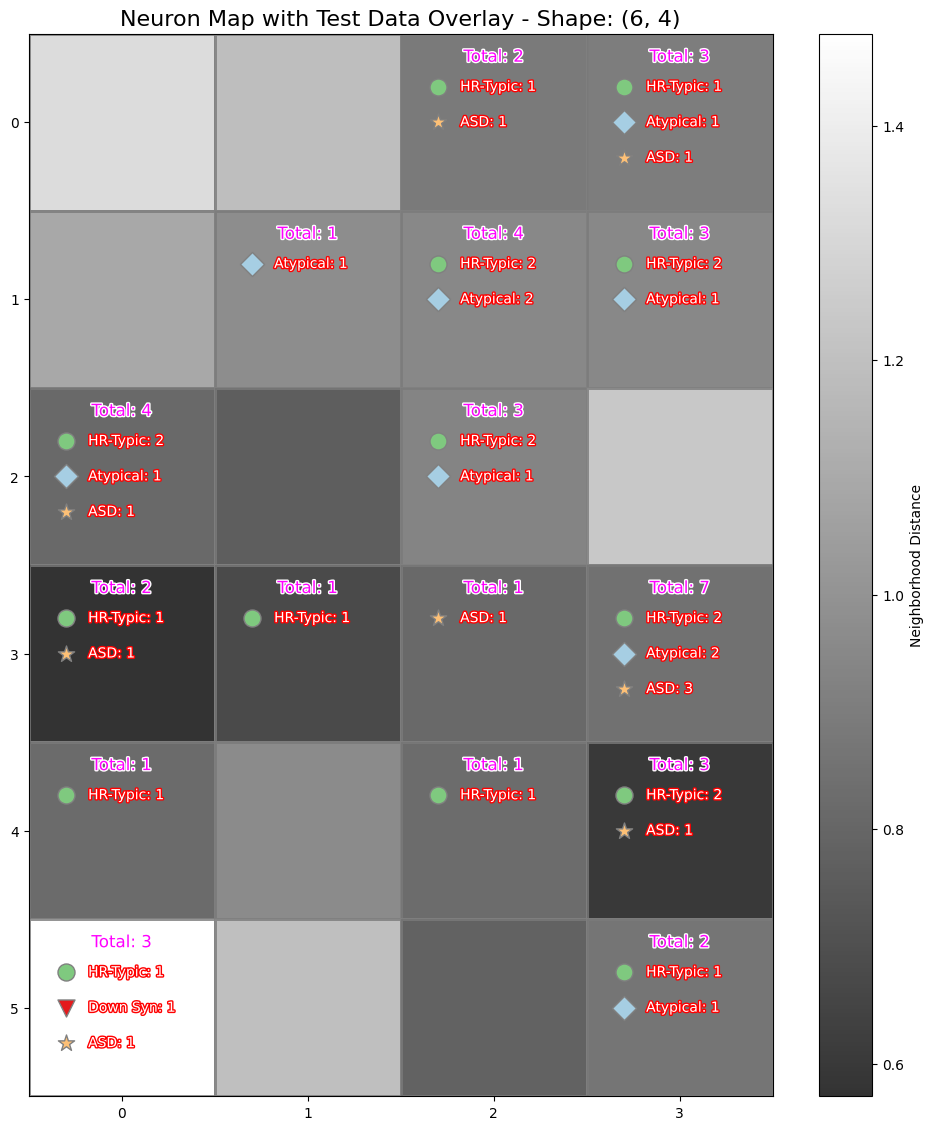

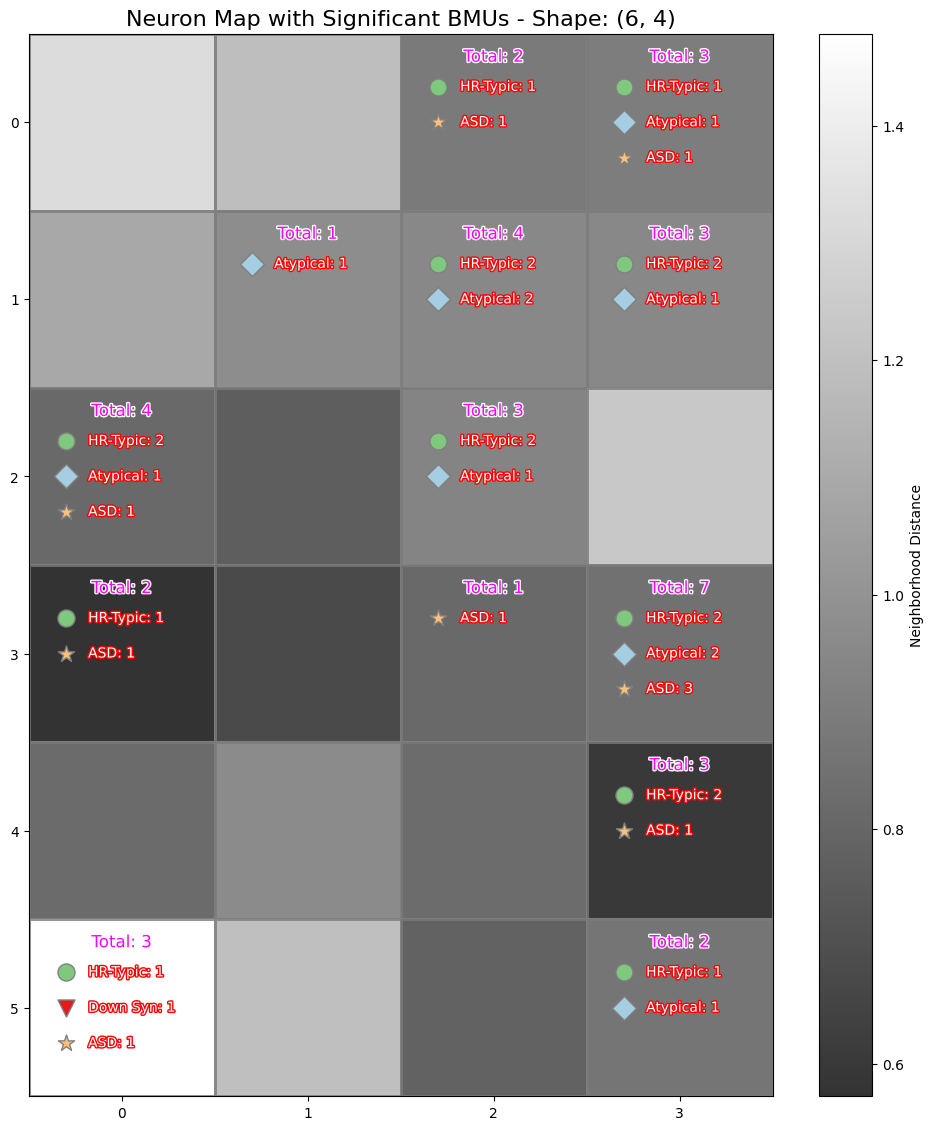

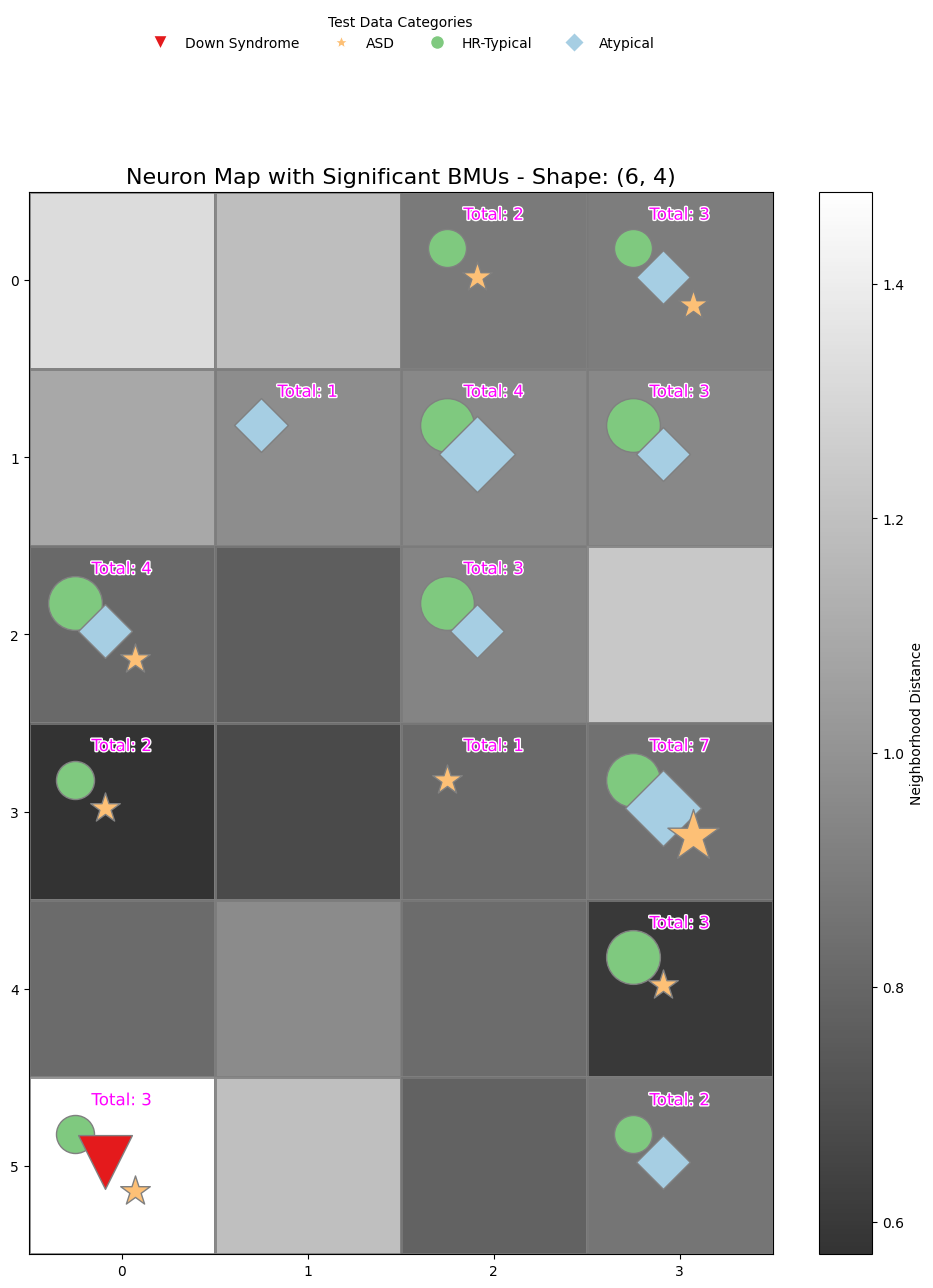

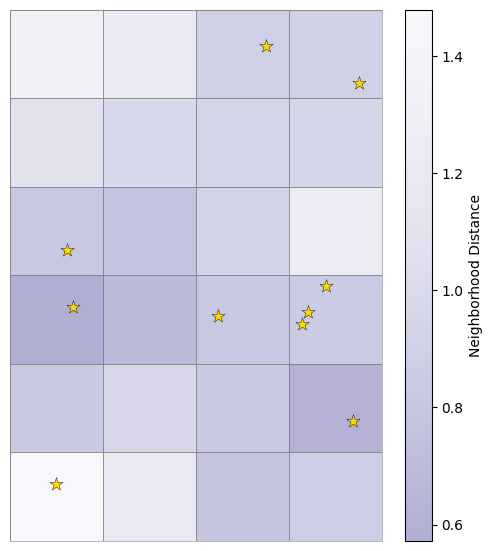

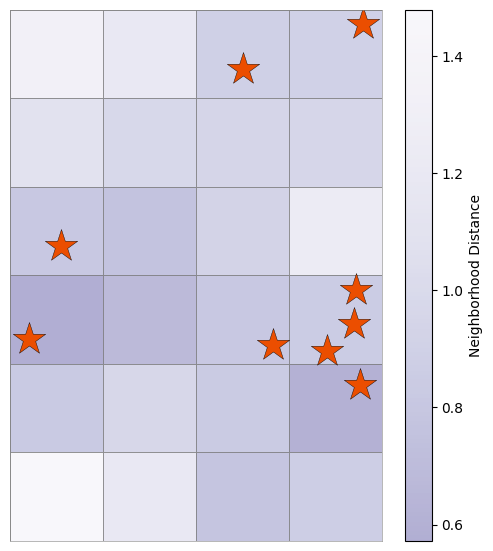

In [88]:
position_list = [(2,3)]

get_and_plot_neuron_by_position_list(train_mapped_zero_unit,test_mapped_zero_unit, position_list, marker_size=600)